# Three simple models test

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Download NVIDIA stock price data
nvidia_stock = yf.download('NVDA', start='2000-01-01', end='2023-01-01')
data = nvidia_stock['Close'].values

# Log difference
data = np.log(data[1:]) - np.log(data[:-1])

# Moving average
window_size = 5
data = np.convolve(data, np.ones(window_size)/window_size, mode='valid')

# Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

# Splitting the data into training, validation, and test sets
split_point_1 = int(len(data_scaled) * 0.8)
split_point_2 = int(len(data_scaled) * 0.9)

train_data = data_scaled[:split_point_1]
valid_data = data_scaled[split_point_1:split_point_2]
test_data = data_scaled[split_point_2:]


[*********************100%%**********************]  1 of 1 completed


In [3]:
def create_rnn_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(50, return_sequences=True, input_shape=(None, 1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.SimpleRNN(50),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_lstm_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(None, 1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def create_gru_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.GRU(50, return_sequences=True, input_shape=(None, 1)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GRU(50),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [2]:
# Function to create time-series data
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        X.append(dataset[i:(i + look_back), 0])
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 1
X_train, Y_train = create_dataset(train_data, look_back)
X_valid, Y_valid = create_dataset(valid_data, look_back)
X_test, Y_test = create_dataset(test_data, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_valid = np.reshape(X_valid, (X_valid.shape[0], X_valid.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [6]:
# Create and train the models
rnn_model = create_rnn_model()
lstm_model = create_lstm_model()
gru_model = create_gru_model()

rnn_history = rnn_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)
lstm_history = lstm_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)
gru_history = gru_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/50
145/145 [==============================] - 3s 16ms/step - loss: 0.0057 - val_loss: 9.5721e-04
Epoch 2/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0015 - val_loss: 9.3716e-04
Epoch 4/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0014 - val_loss: 8.7791e-04
Epoch 5/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 8.7479e-04
Epoch 6/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 8.2629e-04
Epoch 7/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 8.8989e-04
Epoch 8/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 8.5009e-04
Epoch 9/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 8.7430e-04
Epoch 10/50
145/145 [==============================] - 2s 1

In [4]:
def evaluate_model(model, X_test, Y_test):
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    Y_test_scaled = scaler.inverse_transform([Y_test])
    rmse = np.sqrt(mean_squared_error(Y_test_scaled[0], predictions[:,0]))
    mae = mean_absolute_error(Y_test_scaled[0], predictions[:,0])
    return rmse, mae

rnn_rmse, rnn_mae = evaluate_model(rnn_model, X_test, Y_test)
lstm_rmse, lstm_mae = evaluate_model(lstm_model, X_test, Y_test)
gru_rmse, gru_mae = evaluate_model(gru_model, X_test, Y_test)

print("RNN - RMSE:", rnn_rmse, "MAE:", rnn_mae)
print("LSTM - RMSE:", lstm_rmse, "MAE:", lstm_mae)
print("GRU - RMSE:", gru_rmse, "MAE:", gru_mae)

19/19 [==============================] - 0s 9ms/step
RNN - RMSE: 0.009152456241240213 MAE: 0.007046147790313511
LSTM - RMSE: 0.008858897153945146 MAE: 0.006791187592230868
GRU - RMSE: 0.008782916927322361 MAE: 0.006747911320130371


<module 'matplotlib.pyplot' from '/opt/homebrew/Caskroom/miniforge/base/envs/tf/lib/python3.10/site-packages/matplotlib/pyplot.py'>

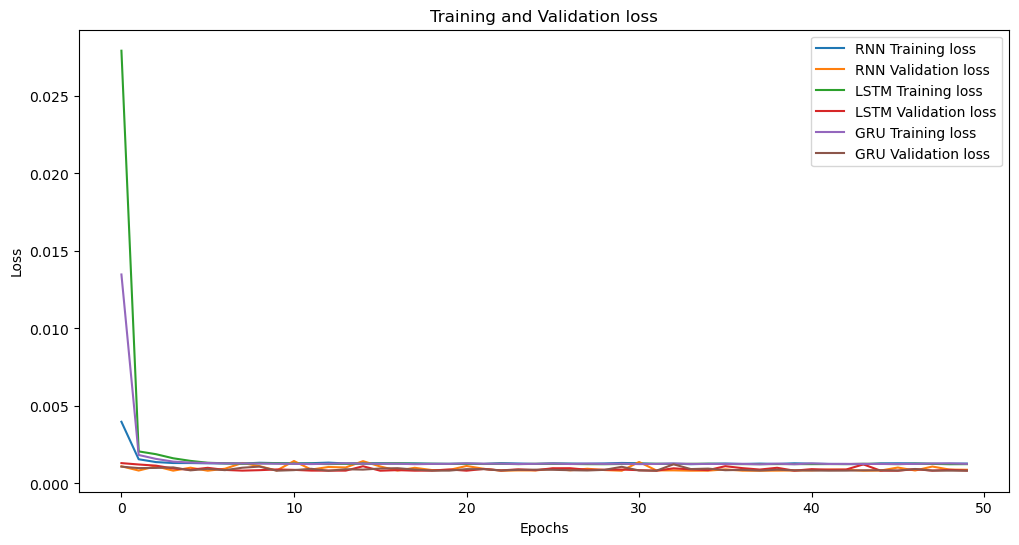

In [7]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(rnn_history.history['loss'], label='RNN Training loss')
plt.plot(rnn_history.history['val_loss'], label='RNN Validation loss')
plt.plot(lstm_history.history['loss'], label='LSTM Training loss')
plt.plot(lstm_history.history['val_loss'], label='LSTM Validation loss')
plt.plot(gru_history.history['loss'], label='GRU Training loss')
plt.plot(gru_history.history['val_loss'], label='GRU Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt


19/19 [==============================] - 0s 3ms/step


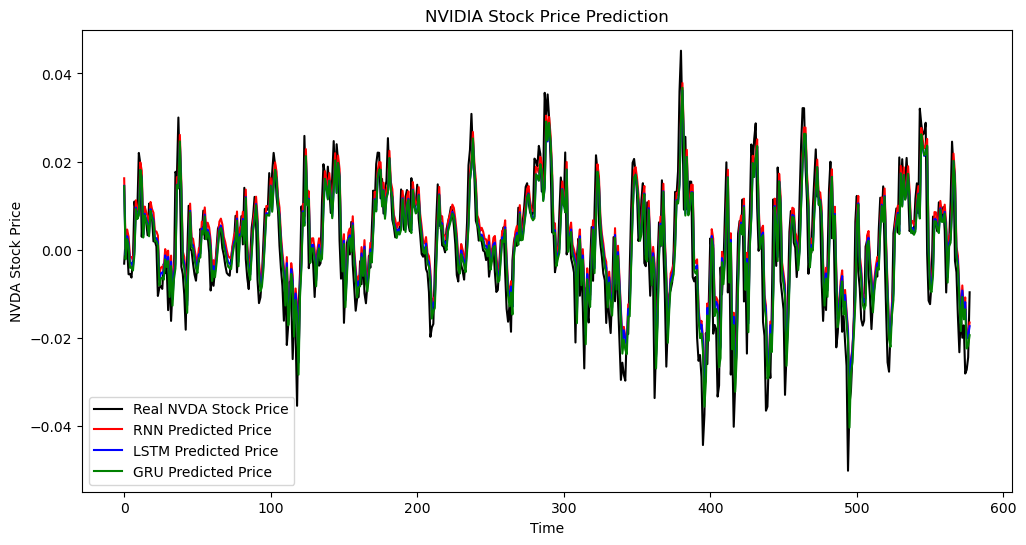

In [6]:
# Function to generate predictions
def generate_predictions(model, X_test):
    predictions = model.predict(X_test)
    return scaler.inverse_transform(predictions)

# Generate predictions
rnn_predictions = generate_predictions(rnn_model, X_test)
lstm_predictions = generate_predictions(lstm_model, X_test)
gru_predictions = generate_predictions(gru_model, X_test)

# Extract the real prices from the test data
real_prices = scaler.inverse_transform(test_data[look_back:])

import matplotlib.pyplot as plt

# Creating the plot
plt.figure(figsize=(12, 6))
plt.plot(real_prices, color='black', label='Real NVDA Stock Price')
plt.plot(rnn_predictions, color='red', label='RNN Predicted Price')
plt.plot(lstm_predictions, color='blue', label='LSTM Predicted Price')
plt.plot(gru_predictions, color='green', label='GRU Predicted Price')

plt.title('NVIDIA Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('NVDA Stock Price')
plt.legend()
plt.show()


# LSTM layers and units

Training model with 1 layers and 15 units...
Epoch 1/50
145/145 [==============================] - 2s 9ms/step - loss: 0.0533 - val_loss: 0.0025
Epoch 2/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0050 - val_loss: 0.0013
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0042 - val_loss: 0.0013
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0013
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 10/50
145/145 [==============================] - 

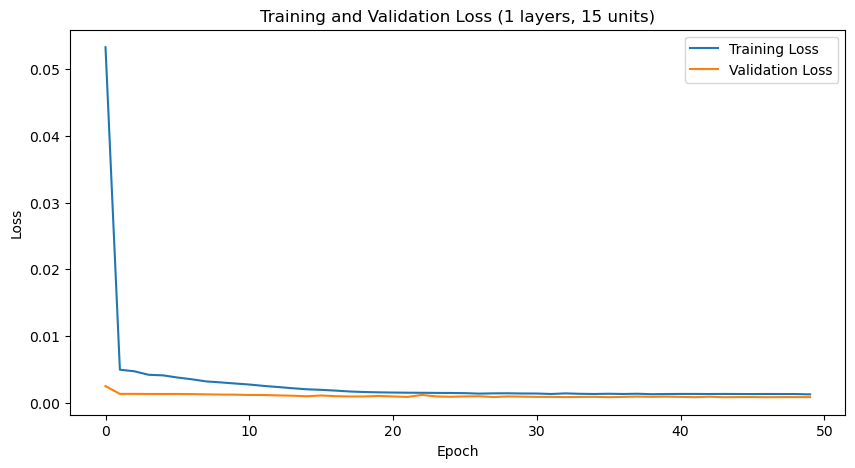

Training model with 1 layers and 30 units...
Epoch 1/50
145/145 [==============================] - 2s 10ms/step - loss: 0.0415 - val_loss: 0.0014
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0032 - val_loss: 0.0013
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 9.8558e-04
Epoch 10/50
145/145 [=============================

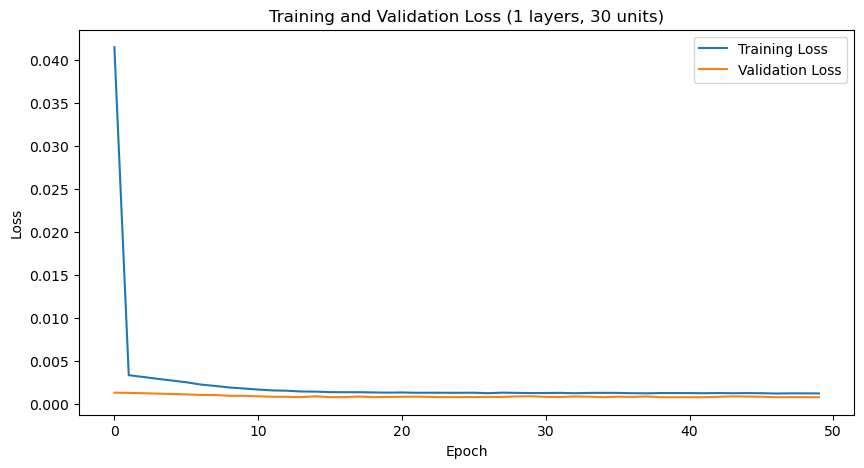

Training model with 1 layers and 60 units...
Epoch 1/50
145/145 [==============================] - 2s 10ms/step - loss: 0.0331 - val_loss: 0.0013
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0020 - val_loss: 0.0011
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 9.9901e-04
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 9.6156e-04
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 9.1706e-04
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 9.5154e-04
Epoch 10/50
145/145 [=================

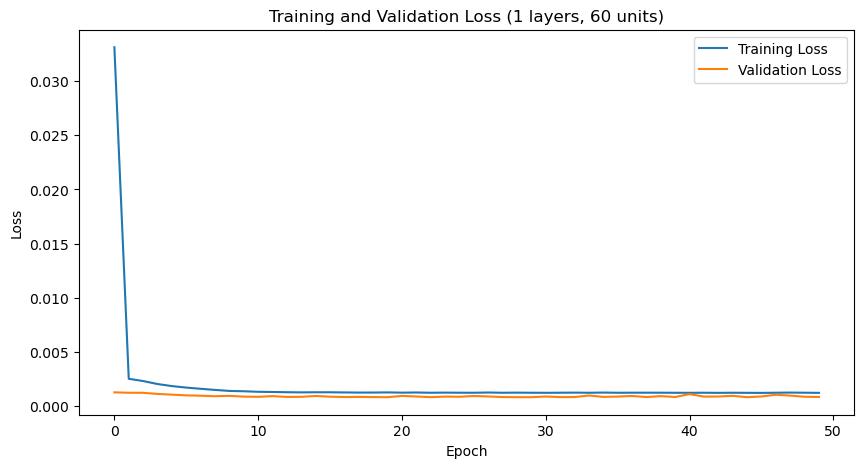

Training model with 2 layers and 15 units...
Epoch 1/50
145/145 [==============================] - 3s 14ms/step - loss: 0.0424 - val_loss: 0.0022
Epoch 2/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0058 - val_loss: 0.0024
Epoch 3/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0051 - val_loss: 0.0020
Epoch 4/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0044 - val_loss: 0.0022
Epoch 5/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0040 - val_loss: 0.0024
Epoch 6/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 7/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0029 - val_loss: 0.0021
Epoch 8/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0024 - val_loss: 0.0025
Epoch 9/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0020 - val_loss: 0.0025
Epoch 10/50
145/145 [=========================

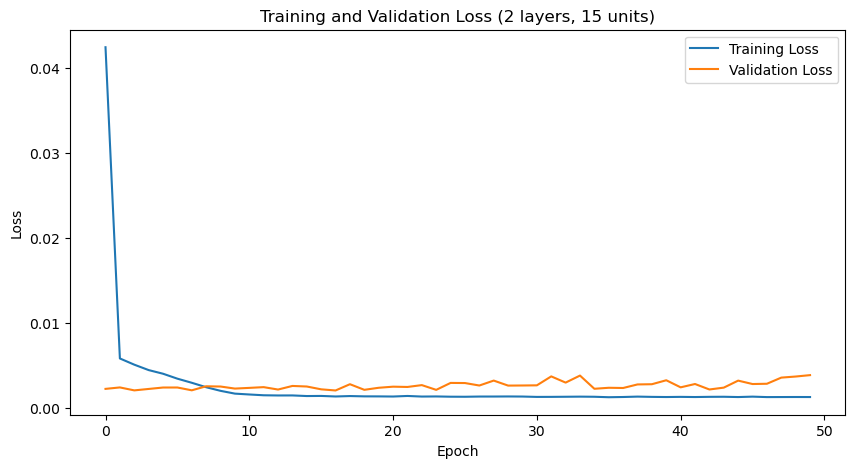

Training model with 2 layers and 30 units...
Epoch 1/50
145/145 [==============================] - 4s 15ms/step - loss: 0.0387 - val_loss: 0.0014
Epoch 2/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 3/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 4/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 5/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0024 - val_loss: 0.0010
Epoch 6/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0020 - val_loss: 9.3936e-04
Epoch 7/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0017 - val_loss: 8.9029e-04
Epoch 8/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 9/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0014 - val_loss: 8.3558e-04
Epoch 10/50
145/145 [=============

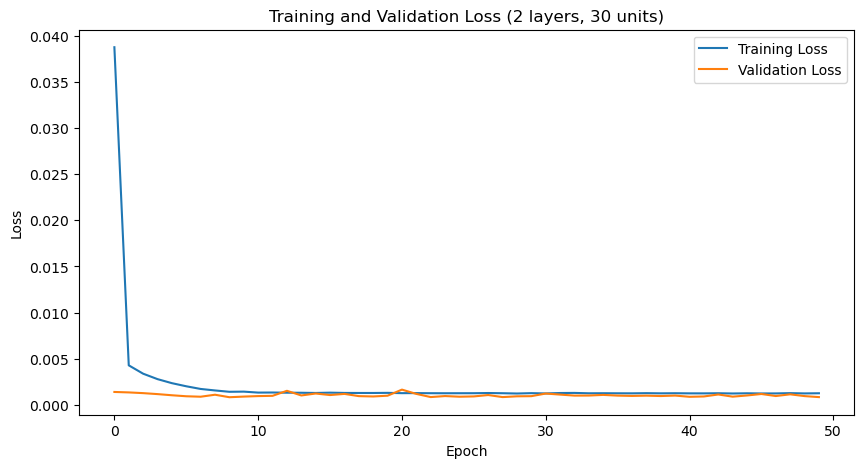

Training model with 2 layers and 60 units...
Epoch 1/50
145/145 [==============================] - 3s 15ms/step - loss: 0.0251 - val_loss: 0.0013
Epoch 2/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 3/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 4/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0016 - val_loss: 9.1084e-04
Epoch 5/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0014 - val_loss: 9.2700e-04
Epoch 6/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 8.6022e-04
Epoch 7/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 8.2604e-04
Epoch 8/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0013 - val_loss: 8.3417e-04
Epoch 9/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 8.8332e-04
Epoch 10/50
145/145 [=

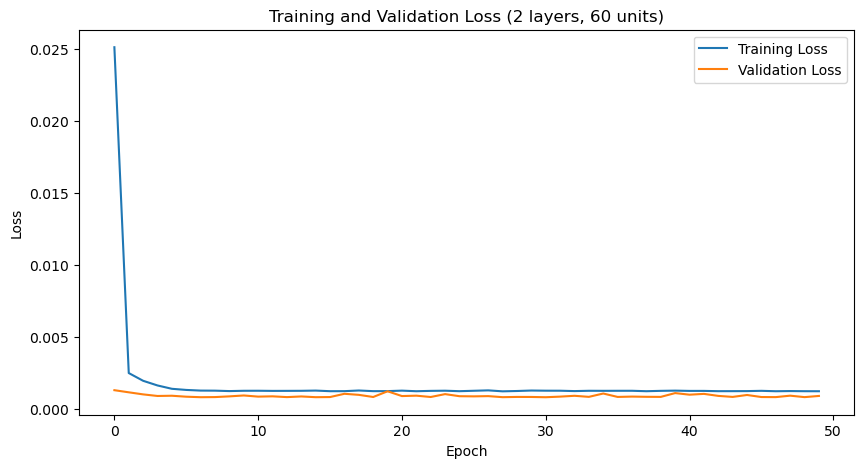

Training model with 4 layers and 15 units...
Epoch 1/50
145/145 [==============================] - 6s 24ms/step - loss: 0.0458 - val_loss: 0.0036
Epoch 2/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0076 - val_loss: 0.0032
Epoch 3/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0060 - val_loss: 0.0029
Epoch 4/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0049 - val_loss: 0.0026
Epoch 5/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 6/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0037 - val_loss: 0.0024
Epoch 7/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 8/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 9/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 10/50
145/145 [=========================

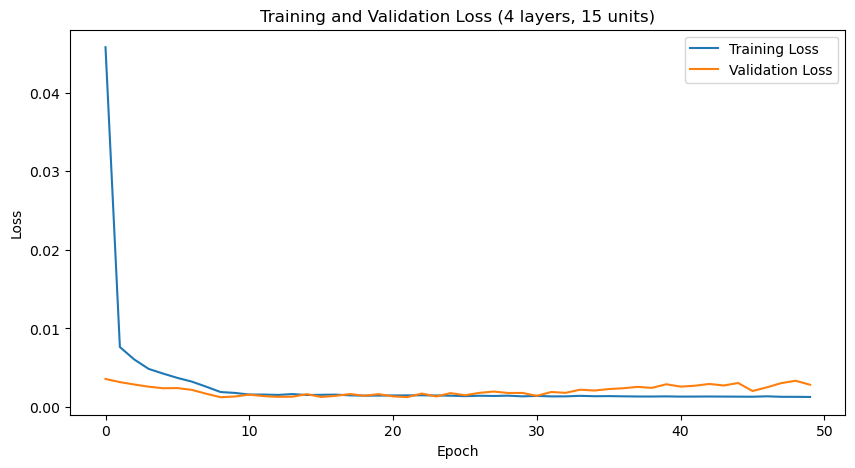

Training model with 4 layers and 30 units...
Epoch 1/50
145/145 [==============================] - 6s 25ms/step - loss: 0.0376 - val_loss: 0.0020
Epoch 2/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0053 - val_loss: 0.0020
Epoch 3/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0042 - val_loss: 0.0020
Epoch 4/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0036 - val_loss: 0.0019
Epoch 5/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0026 - val_loss: 0.0013
Epoch 6/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 7/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0015 - val_loss: 8.4963e-04
Epoch 8/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0014 - val_loss: 8.4265e-04
Epoch 9/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 10/50
145/145 [=================

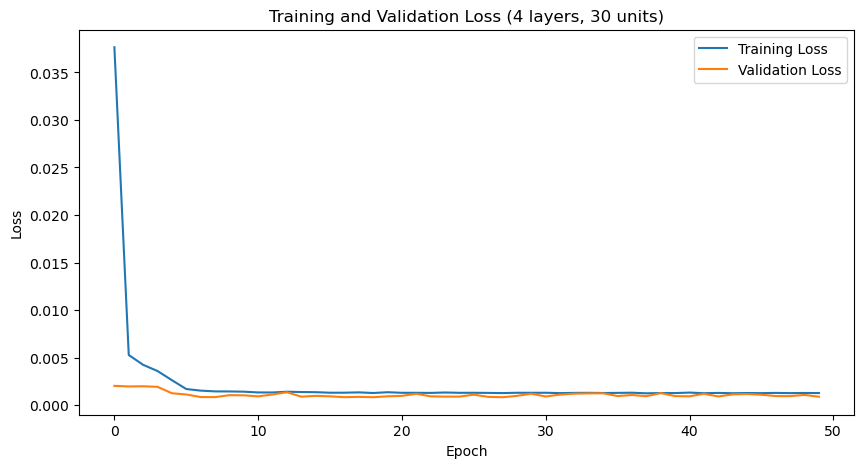

Training model with 4 layers and 60 units...
Epoch 1/50
145/145 [==============================] - 7s 27ms/step - loss: 0.0242 - val_loss: 0.0018
Epoch 2/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0031 - val_loss: 0.0015
Epoch 3/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 4/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0015 - val_loss: 9.7931e-04
Epoch 5/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 6/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 8/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0013 - val_loss: 9.2894e-04
Epoch 9/50
145/145 [==============================] - 3s 19ms/step - loss: 0.0013 - val_loss: 9.7169e-04
Epoch 10/50
145/145 [=============

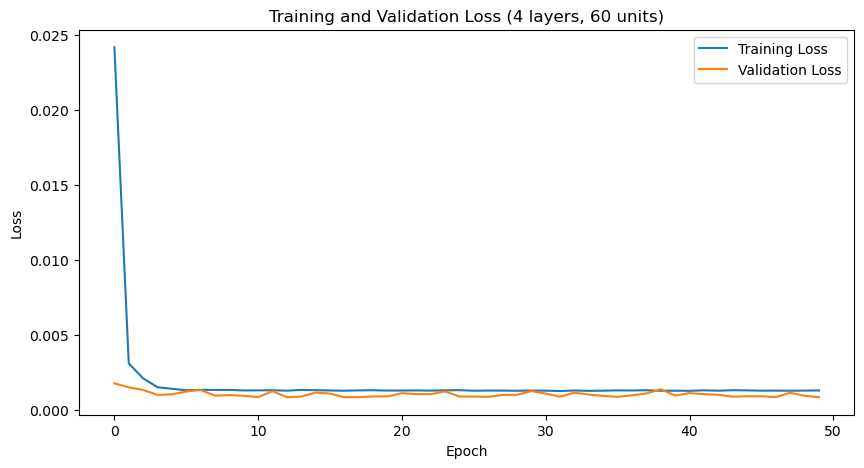

Layers: 1, Units: 15 --> RMSE: 0.029088901880993175, MAE: 0.022439031036575942
Layers: 1, Units: 30 --> RMSE: 0.02886573224933365, MAE: 0.022140884929747254
Layers: 1, Units: 60 --> RMSE: 0.029315902329516683, MAE: 0.022491232954120175
Layers: 2, Units: 15 --> RMSE: 0.06099668615469422, MAE: 0.054659736336212975
Layers: 2, Units: 30 --> RMSE: 0.02916247001504169, MAE: 0.022521726588845485
Layers: 2, Units: 60 --> RMSE: 0.030563427403493302, MAE: 0.023638338366834735
Layers: 4, Units: 15 --> RMSE: 0.05216864030634395, MAE: 0.044679998052193845
Layers: 4, Units: 30 --> RMSE: 0.029662859481044277, MAE: 0.023045196968987276
Layers: 4, Units: 60 --> RMSE: 0.02888351504148658, MAE: 0.022211486634413406


In [4]:
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import numpy as np

# Assuming you have already preprocessed the data and created the datasets:
# X_train, Y_train, X_valid, Y_valid, X_test, Y_test

# Define model creation function
def create_model(num_layers, num_units):
    model = Sequential()
    for i in range(num_layers):
        model.add(LSTM(units=num_units, return_sequences=(i < num_layers - 1)))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Define your grid search parameters
layer_options = [1, 2, 4]  # Example: 1, 2, or 4 layers
unit_options = [15, 30, 60]  # Example: 15, 30, or 60 units per layer

# Store results
results = []

# Perform grid search
for layers in layer_options:
    for units in unit_options:
        print(f"Training model with {layers} layers and {units} units...")
        model = create_model(num_layers=layers, num_units=units)
        history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)
        
        # Evaluate model
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, predictions))
        mae = mean_absolute_error(Y_test, predictions)
        
        # Store metrics
        results.append((layers, units, rmse, mae))
        
        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"Training and Validation Loss ({layers} layers, {units} units)")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# After grid search, print the results
for result in results:
    layers, units, rmse, mae = result
    print(f"Layers: {layers}, Units: {units} --> RMSE: {rmse}, MAE: {mae}")


# LSTM optimizer and learning rate

In [6]:
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

def create_lstm_model(optimizer_name, learning_rate):
    model = Sequential()
    model.add(LSTM(30, input_shape=(None, 1)))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    
    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model


Training model with adam optimizer and learning rate 0.001...
Epoch 1/50


2023-11-24 08:30:41.437198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


145/145 [==============================] - 2s 10ms/step - loss: 0.0397 - val_loss: 0.0013
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0010
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 9.9709e-04
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 9.6434e-04
E

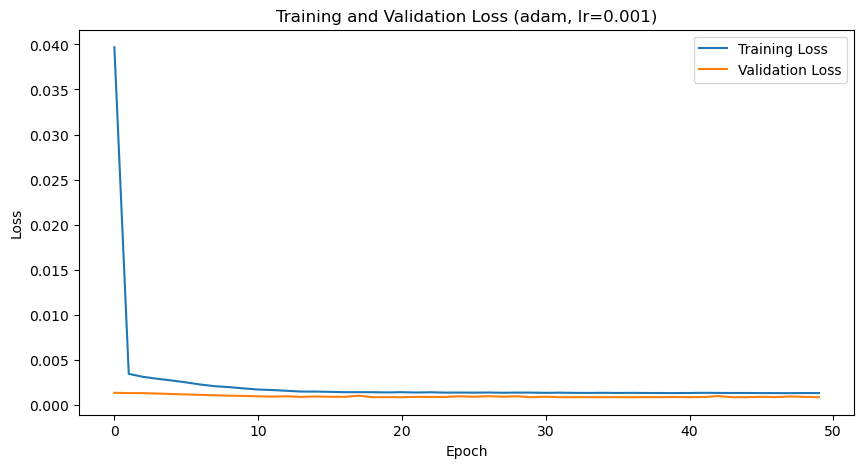

Training model with adam optimizer and learning rate 0.01...


Epoch 1/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0083 - val_loss: 0.0013
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 8.6726e-04
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 8.2997e-04
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 8.2577e-04
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 9.8630e-04
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 8.3572e-04
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 8.4853e-04
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 

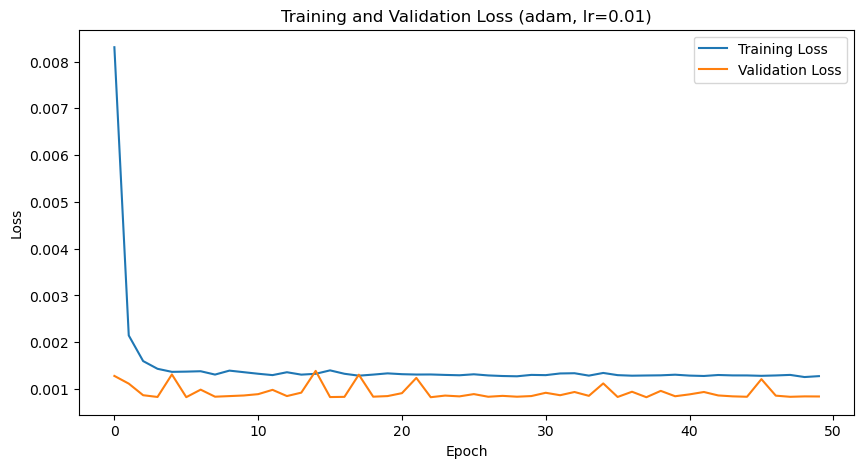

Training model with adam optimizer and learning rate 0.1...


Epoch 1/50


2023-11-24 08:32:32.955267: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


145/145 [==============================] - 2s 10ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 0.0017
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 8.6538e-04
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0021
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 10/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch

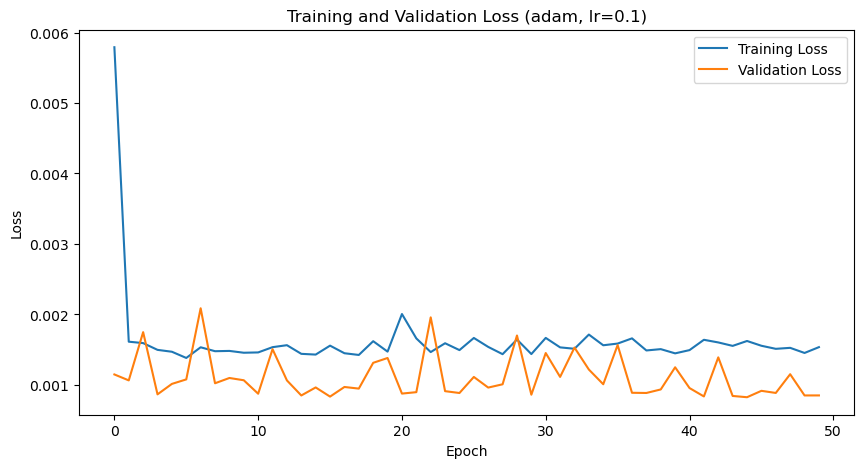

Training model with rmsprop optimizer and learning rate 0.001...


Epoch 1/50
145/145 [==============================] - 3s 14ms/step - loss: 0.0356 - val_loss: 0.0016
Epoch 2/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0011
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 9.7967e-04
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 9.3936e-04
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 8.7460e-04
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 8.5085e-04
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 9.7880e-04
Epoch 10/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0

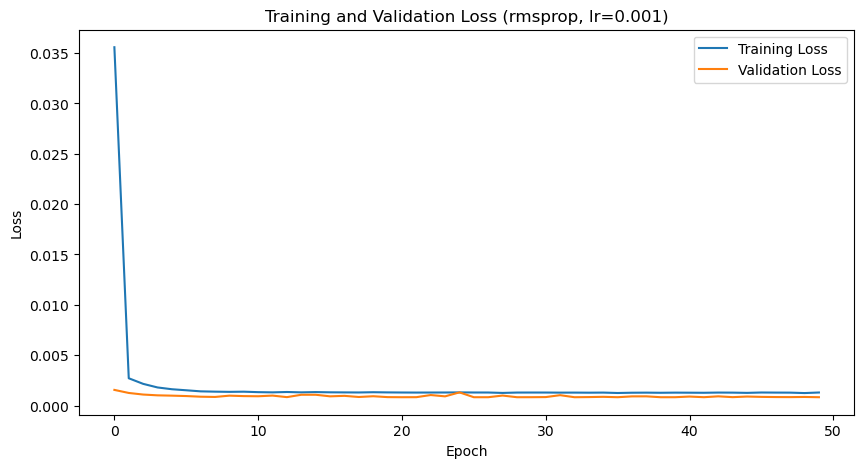

Training model with rmsprop optimizer and learning rate 0.01...


Epoch 1/50
145/145 [==============================] - 3s 13ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 9.7090e-04
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 9.2155e-04
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 8.9927e-04
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 8.4949e-04
Epoch 9/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 8.8072e-04
Epoch 10/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0

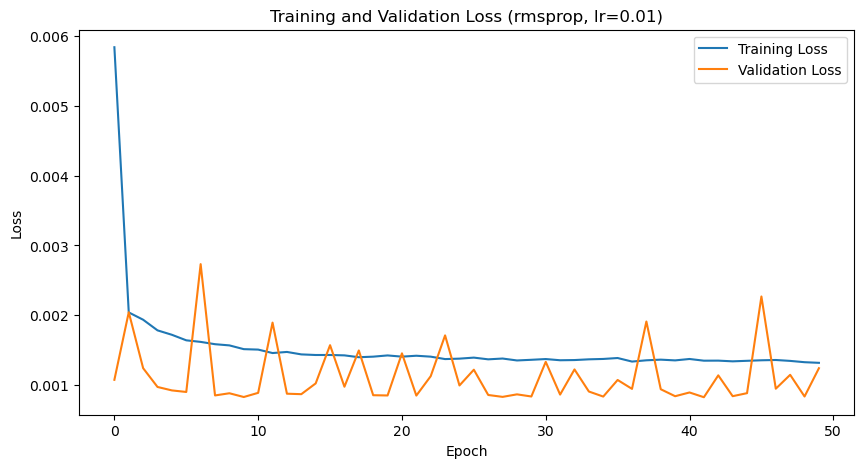

Training model with rmsprop optimizer and learning rate 0.1...


Epoch 1/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0320 - val_loss: 0.0059
Epoch 2/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0063 - val_loss: 0.0066
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0060 - val_loss: 0.0095
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0058 - val_loss: 0.0042
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.0023
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0018
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0048 - val_loss: 0.0093
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0071
Epoch 10/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0048 - val_loss: 0.00

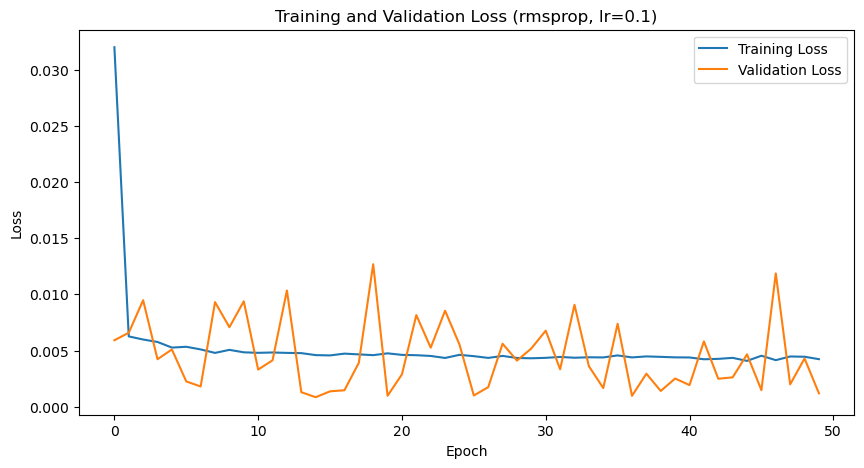

Training model with sgd optimizer and learning rate 0.001...


Epoch 1/50


2023-11-24 08:36:55.150011: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp_4.


145/145 [==============================] - 2s 10ms/step - loss: 0.1089 - val_loss: 0.0770
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0579 - val_loss: 0.0409
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0316 - val_loss: 0.0222
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0179 - val_loss: 0.0124
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0108 - val_loss: 0.0074
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0072 - val_loss: 0.0048
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0053 - val_loss: 0.0035
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0043 - val_loss: 0.0028
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 10/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0022
Epoch 11/

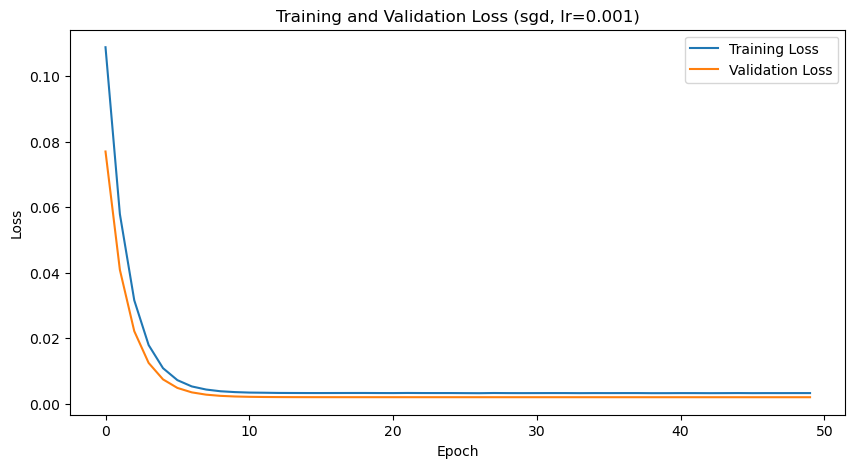

Training model with sgd optimizer and learning rate 0.01...


Epoch 1/50
145/145 [==============================] - 2s 10ms/step - loss: 0.0248 - val_loss: 0.0021
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 0.0019
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 10/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0031 - val_loss: 0.001

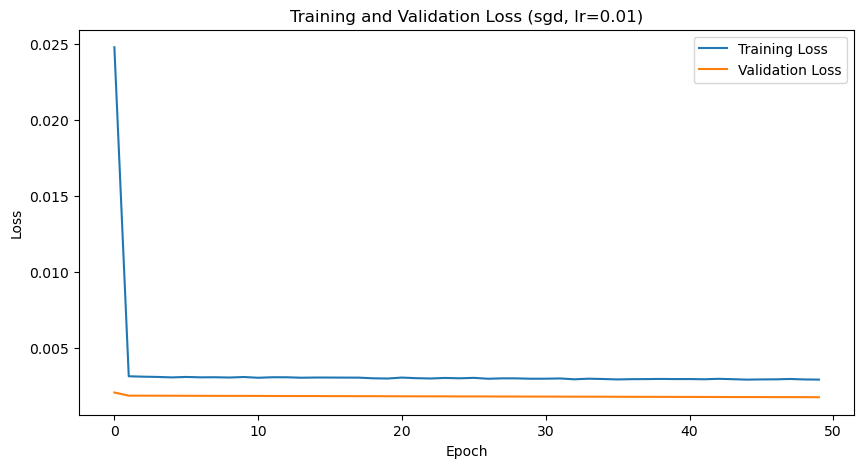

Training model with sgd optimizer and learning rate 0.1...


Epoch 1/50


2023-11-24 08:38:46.288463: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp_4.


145/145 [==============================] - 2s 11ms/step - loss: 0.0066 - val_loss: 0.0022
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0021
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 0.0020
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0032 - val_loss: 0.0020
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 11/

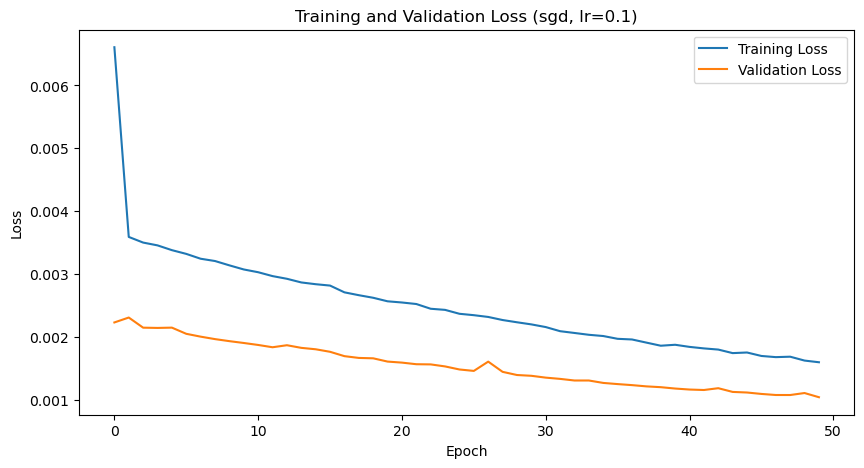

Optimizer: adam, Learning Rate: 0.001 --> RMSE: 0.028889099350800113, MAE: 0.022153067299771796
Optimizer: adam, Learning Rate: 0.01 --> RMSE: 0.029048236406058105, MAE: 0.022318356001068948
Optimizer: adam, Learning Rate: 0.1 --> RMSE: 0.029183886454232186, MAE: 0.022542517468338755
Optimizer: rmsprop, Learning Rate: 0.001 --> RMSE: 0.028864082553667406, MAE: 0.022150479893907733
Optimizer: rmsprop, Learning Rate: 0.01 --> RMSE: 0.0356393035143568, MAE: 0.02828172244817038
Optimizer: rmsprop, Learning Rate: 0.1 --> RMSE: 0.03470692021826427, MAE: 0.027404234521947433
Optimizer: sgd, Learning Rate: 0.001 --> RMSE: 0.04564677542044636, MAE: 0.03560562837852235
Optimizer: sgd, Learning Rate: 0.01 --> RMSE: 0.0434794793264275, MAE: 0.03388475493068412
Optimizer: sgd, Learning Rate: 0.1 --> RMSE: 0.03270661105720748, MAE: 0.025330603682023722


In [7]:
# Define your grid search parameters
optimizers = ['adam', 'rmsprop', 'sgd']
learning_rates = [0.001, 0.01, 0.1]  # Example learning rates, adjust as needed

# Store results
results = []

# Perform grid search
for optimizer_name in optimizers:
    for lr in learning_rates:
        print(f"Training model with {optimizer_name} optimizer and learning rate {lr}...")
        model = create_lstm_model(optimizer_name=optimizer_name, learning_rate=lr)
        history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)
        
        # Evaluate model
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, predictions))
        mae = mean_absolute_error(Y_test, predictions)
        
        # Store metrics
        results.append((optimizer_name, lr, rmse, mae))
        
        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"Training and Validation Loss ({optimizer_name}, lr={lr})")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# Print the results
for result in results:
    optimizer_name, lr, rmse, mae = result
    print(f"Optimizer: {optimizer_name}, Learning Rate: {lr} --> RMSE: {rmse}, MAE: {mae}")

# Bidirational LSTM

In [8]:
from tensorflow.keras.layers import Input, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential

def create_bidirectional_lstm_model(num_units, num_layers, input_shape):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            # First layer needs to specify the input shape
            model.add(Bidirectional(LSTM(num_units, return_sequences=(num_layers > 1)), input_shape=input_shape))
        else:
            # Last layer should not return sequences
            model.add(Bidirectional(LSTM(num_units, return_sequences=(i < num_layers - 1))))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Training model with 1 layers and 15 units...
Epoch 1/50
145/145 [==============================] - 4s 17ms/step - loss: 0.0463 - val_loss: 0.0014
Epoch 2/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 3/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0031 - val_loss: 0.0013
Epoch 4/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 5/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 6/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 7/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 8/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 9/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0019 - val_loss: 9.9481e-04
Epoch 10/50
145/145 [=====================

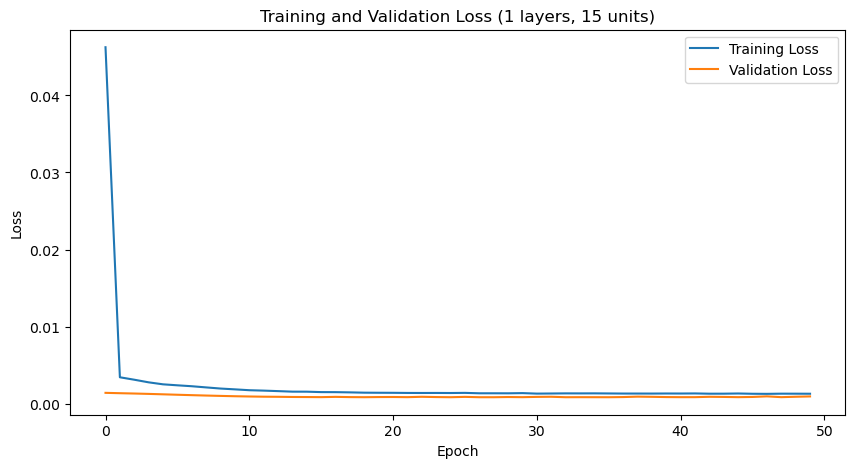

Training model with 1 layers and 30 units...
Epoch 1/50
145/145 [==============================] - 3s 16ms/step - loss: 0.0310 - val_loss: 0.0013
Epoch 2/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0023 - val_loss: 0.0012
Epoch 3/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 4/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 5/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 6/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 7/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0016 - val_loss: 9.3791e-04
Epoch 8/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0015 - val_loss: 9.0353e-04
Epoch 9/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0014 - val_loss: 8.6683e-04
Epoch 10/50
145/145 [=============

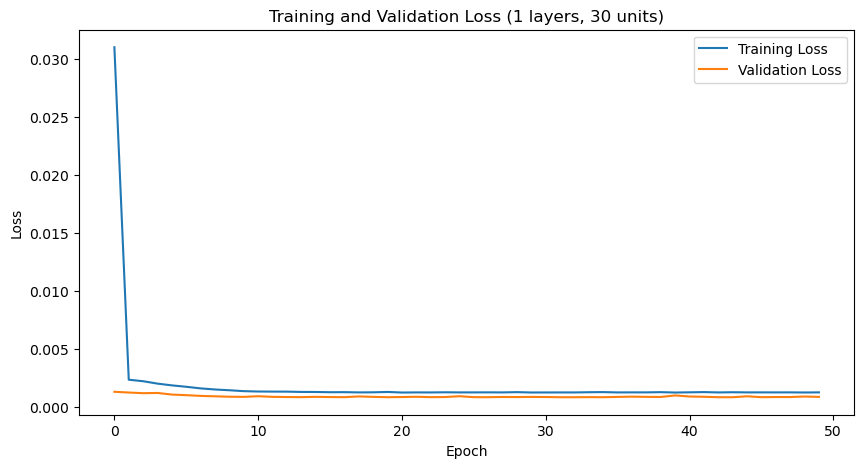

Training model with 1 layers and 60 units...
Epoch 1/50
145/145 [==============================] - 3s 16ms/step - loss: 0.0253 - val_loss: 0.0014
Epoch 2/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 3/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 4/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0019 - val_loss: 0.0013
Epoch 5/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 6/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 7/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/50
145/145 [=========================

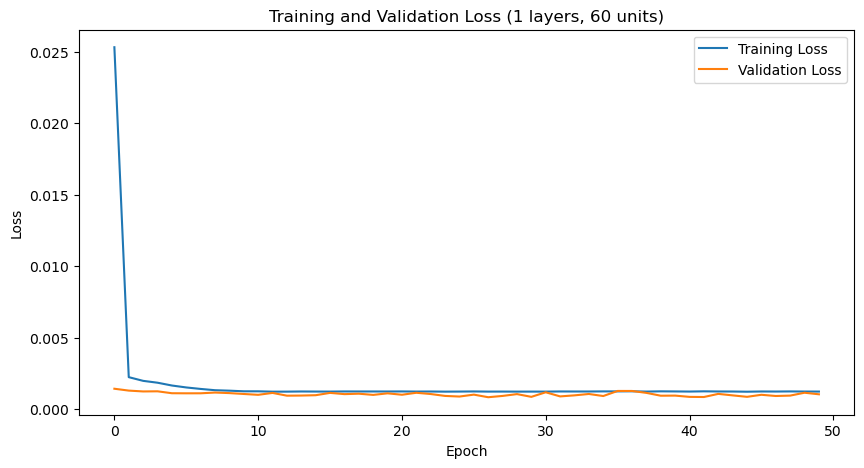

Training model with 2 layers and 15 units...
Epoch 1/50
145/145 [==============================] - 6s 27ms/step - loss: 0.0331 - val_loss: 0.0013
Epoch 2/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 3/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0034 - val_loss: 0.0013
Epoch 4/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 5/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 6/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0021 - val_loss: 9.5193e-04
Epoch 7/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 8/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0015 - val_loss: 8.7914e-04
Epoch 9/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0015 - val_loss: 9.4783e-04
Epoch 10/50
145/145 [=============

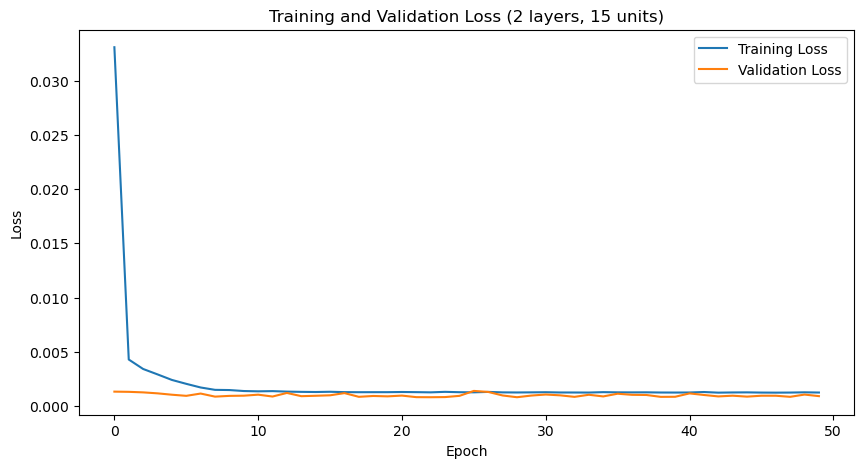

Training model with 2 layers and 30 units...
Epoch 1/50
145/145 [==============================] - 6s 28ms/step - loss: 0.0224 - val_loss: 0.0011
Epoch 2/50
145/145 [==============================] - 3s 21ms/step - loss: 0.0023 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0018 - val_loss: 9.6693e-04
Epoch 4/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0016 - val_loss: 9.0472e-04
Epoch 5/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0014 - val_loss: 8.4853e-04
Epoch 6/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0013 - val_loss: 8.5511e-04
Epoch 7/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0013 - val_loss: 8.3397e-04
Epoch 8/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0013 - val_loss: 8.5144e-04
Epoch 9/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0013 - val_loss: 9.3611e-04
Epoch 10/50
145/14

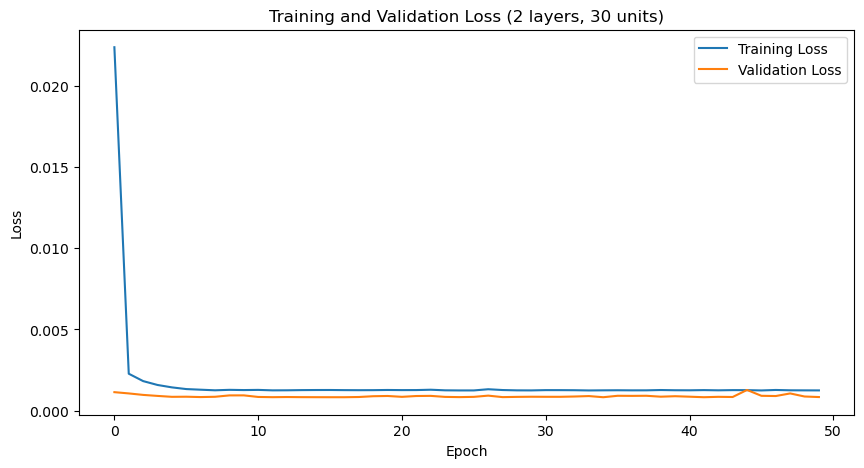

Training model with 2 layers and 60 units...
Epoch 1/50
145/145 [==============================] - 6s 29ms/step - loss: 0.0159 - val_loss: 0.0013
Epoch 2/50
145/145 [==============================] - 3s 21ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 3s 21ms/step - loss: 0.0014 - val_loss: 8.6856e-04
Epoch 4/50
145/145 [==============================] - 3s 21ms/step - loss: 0.0013 - val_loss: 8.3886e-04
Epoch 5/50
145/145 [==============================] - 3s 21ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 6/50
145/145 [==============================] - 3s 21ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7/50
145/145 [==============================] - 3s 20ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 8/50
145/145 [==============================] - 3s 21ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/50
145/145 [==============================] - 3s 21ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/50
145/145 [=================

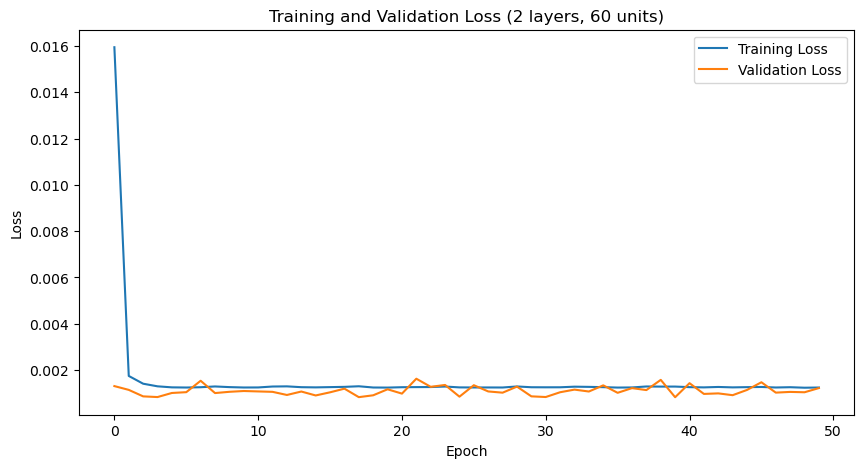

Training model with 3 layers and 15 units...
Epoch 1/50
145/145 [==============================] - 10s 46ms/step - loss: 0.0355 - val_loss: 0.0016
Epoch 2/50
145/145 [==============================] - 4s 31ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 3/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0036 - val_loss: 0.0014
Epoch 4/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0029 - val_loss: 0.0012
Epoch 5/50
145/145 [==============================] - 4s 29ms/step - loss: 0.0021 - val_loss: 9.3396e-04
Epoch 6/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0016 - val_loss: 8.5790e-04
Epoch 7/50
145/145 [==============================] - 4s 31ms/step - loss: 0.0015 - val_loss: 0.0010
Epoch 8/50
145/145 [==============================] - 4s 31ms/step - loss: 0.0014 - val_loss: 9.2591e-04
Epoch 9/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0015 - val_loss: 9.6810e-04
Epoch 10/50
145/145 [========

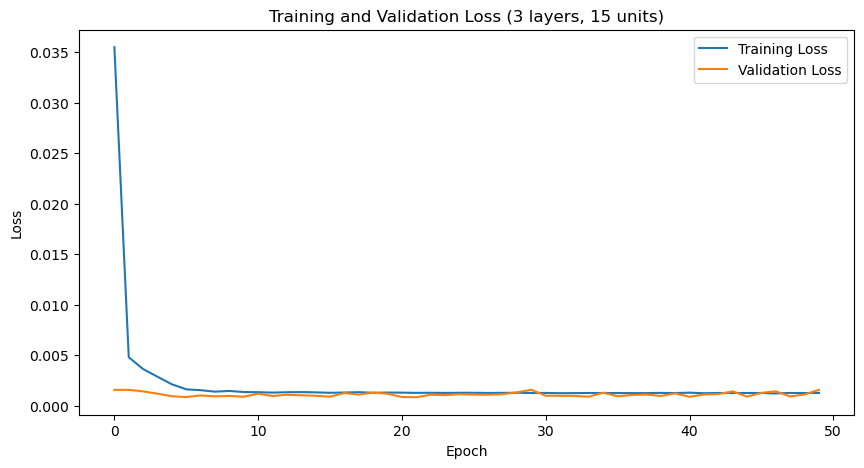

Training model with 3 layers and 30 units...
Epoch 1/50
145/145 [==============================] - 10s 47ms/step - loss: 0.0235 - val_loss: 0.0014
Epoch 2/50
145/145 [==============================] - 5s 36ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 3/50
145/145 [==============================] - 5s 33ms/step - loss: 0.0019 - val_loss: 9.4378e-04
Epoch 4/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0015 - val_loss: 8.3866e-04
Epoch 5/50
145/145 [==============================] - 4s 29ms/step - loss: 0.0013 - val_loss: 8.7607e-04
Epoch 6/50
145/145 [==============================] - 4s 29ms/step - loss: 0.0013 - val_loss: 8.9797e-04
Epoch 7/50
145/145 [==============================] - 4s 29ms/step - loss: 0.0013 - val_loss: 8.5691e-04
Epoch 8/50
145/145 [==============================] - 4s 29ms/step - loss: 0.0013 - val_loss: 8.4865e-04
Epoch 9/50
145/145 [==============================] - 4s 29ms/step - loss: 0.0013 - val_loss: 8.8662e-04
Epoch 10/50
145/1

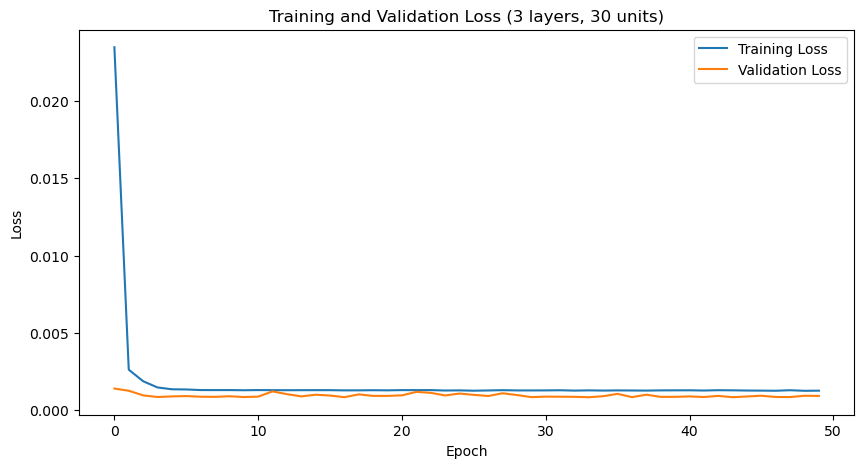

Training model with 3 layers and 60 units...
Epoch 1/50
145/145 [==============================] - 11s 50ms/step - loss: 0.0162 - val_loss: 0.0015
Epoch 2/50
145/145 [==============================] - 5s 33ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 5s 31ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/50
145/145 [==============================] - 4s 30ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 5/50
145/145 [==============================] - 5s 32ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/50
145/145 [==============================] - 5s 32ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 7/50
145/145 [==============================] - 5s 33ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 8/50
145/145 [==============================] - 5s 32ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/50
145/145 [==============================] - 5s 32ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/50
145/145 [========================

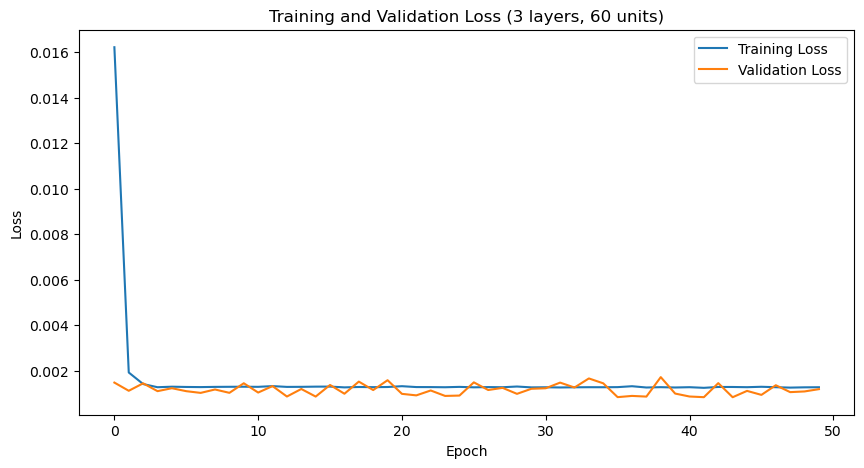

Layers: 1, Units: 15 --> RMSE: 0.030351450304277078, MAE: 0.023809888810075838
Layers: 1, Units: 30 --> RMSE: 0.02922057781810481, MAE: 0.022599136341002416
Layers: 1, Units: 60 --> RMSE: 0.03210293203492991, MAE: 0.02568337852175078
Layers: 2, Units: 15 --> RMSE: 0.030282977655318104, MAE: 0.02372012933295349
Layers: 2, Units: 30 --> RMSE: 0.028959186096177935, MAE: 0.02230937055289928
Layers: 2, Units: 60 --> RMSE: 0.03467227491408809, MAE: 0.02830375109110959
Layers: 3, Units: 15 --> RMSE: 0.0390879088051786, MAE: 0.032694123034959686
Layers: 3, Units: 30 --> RMSE: 0.030459391965179338, MAE: 0.02355237148685258
Layers: 3, Units: 60 --> RMSE: 0.034133938285534966, MAE: 0.027764587875103858


In [9]:
# Define grid search parameters
layer_options = [1, 2, 3]  # Number of Bidirectional LSTM layers to try
unit_options = [15, 30, 60]  # Number of units in each layer to try

# Store results
results = []

# Perform grid search
for num_layers in layer_options:
    for num_units in unit_options:
        print(f"Training model with {num_layers} layers and {num_units} units...")
        # Create the model
        model = create_bidirectional_lstm_model(num_units=num_units, num_layers=num_layers, input_shape=(None, 1))
        # Train the model
        history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)
        
        # Evaluate the model
        predictions = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, predictions))
        mae = mean_absolute_error(Y_test, predictions)
        
        # Store metrics
        results.append((num_layers, num_units, rmse, mae))
        
        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"Training and Validation Loss ({num_layers} layers, {num_units} units)")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# Print the results
for result in results:
    num_layers, num_units, rmse, mae = result
    print(f"Layers: {num_layers}, Units: {num_units} --> RMSE: {rmse}, MAE: {mae}")

# GRU layers and units

In [10]:
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.models import Sequential

def create_gru_model(num_units, num_layers, input_shape):
    model = Sequential()
    for i in range(num_layers):
        if i == 0:
            model.add(GRU(num_units, return_sequences=(num_layers > 1), input_shape=input_shape))
        else:
            model.add(GRU(num_units, return_sequences=(i < num_layers - 1)))
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Epoch 1/50
145/145 [==============================] - 3s 11ms/step - loss: 0.0839 - val_loss: 0.0041
Epoch 2/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0062 - val_loss: 0.0019
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0054 - val_loss: 0.0019
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0043 - val_loss: 0.0018
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0041 - val_loss: 0.0017
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0038 - val_loss: 0.0017
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0015
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.001

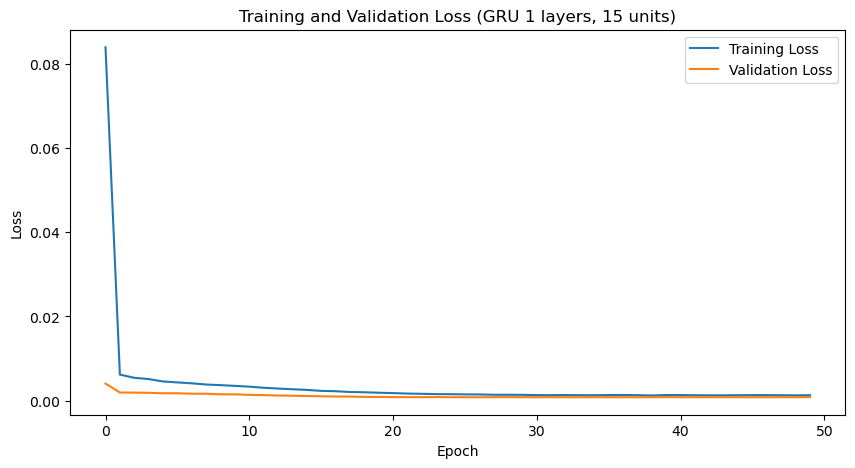

Epoch 1/50
145/145 [==============================] - 2s 10ms/step - loss: 0.0277 - val_loss: 0.0013
Epoch 2/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0013
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0013
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0025 - val_loss: 0.0011
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0023 - val_loss: 0.0010
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 9.6060e-04
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0018 - val_loss: 9.1213e-04
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 8.7700e-04
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0016 - val

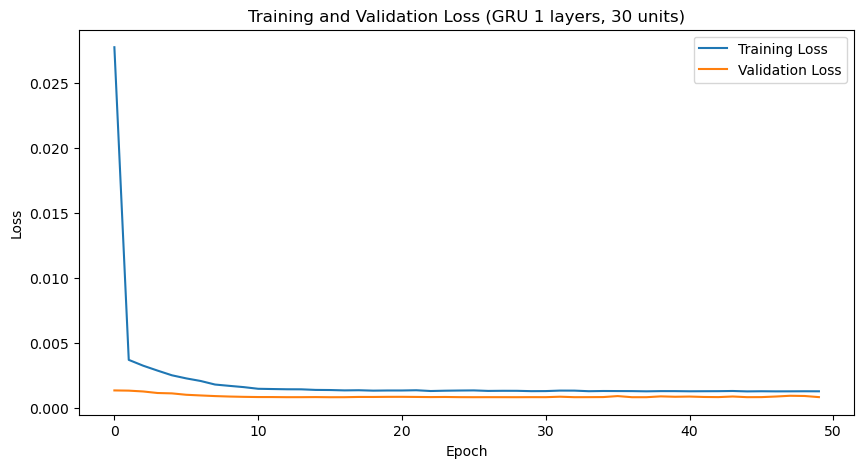

Epoch 1/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0189 - val_loss: 0.0012
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 0.0011
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0010
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 9.4279e-04
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 8.9835e-04
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 8.6749e-04
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 8.4658e-04
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 8.6249e-04
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 0.00

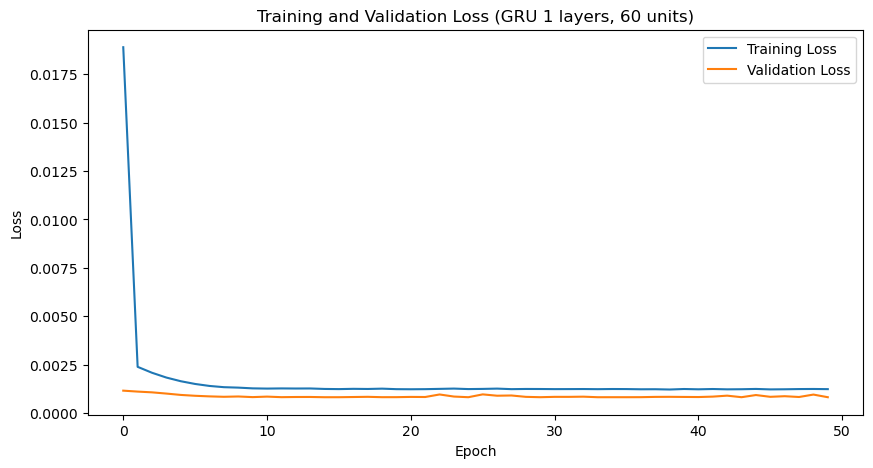

Epoch 1/50
145/145 [==============================] - 4s 16ms/step - loss: 0.0253 - val_loss: 0.0018
Epoch 2/50
145/145 [==============================] - 2s 10ms/step - loss: 0.0056 - val_loss: 0.0021
Epoch 3/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0045 - val_loss: 0.0021
Epoch 4/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 5/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 6/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.0020
Epoch 7/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0024
Epoch 8/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0017 - val_loss: 0.0019
Epoch 9/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0021
Epoch 10/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0015 - val_lo

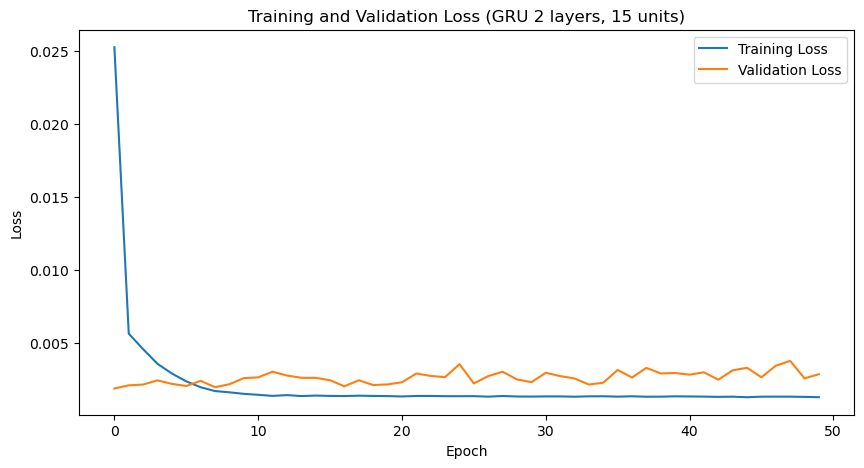

Epoch 1/50
145/145 [==============================] - 4s 16ms/step - loss: 0.0200 - val_loss: 0.0012
Epoch 2/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0039 - val_loss: 0.0012
Epoch 3/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0026 - val_loss: 0.0012
Epoch 4/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 5/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 6/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 7/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 9/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 10/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0013 - val_lo

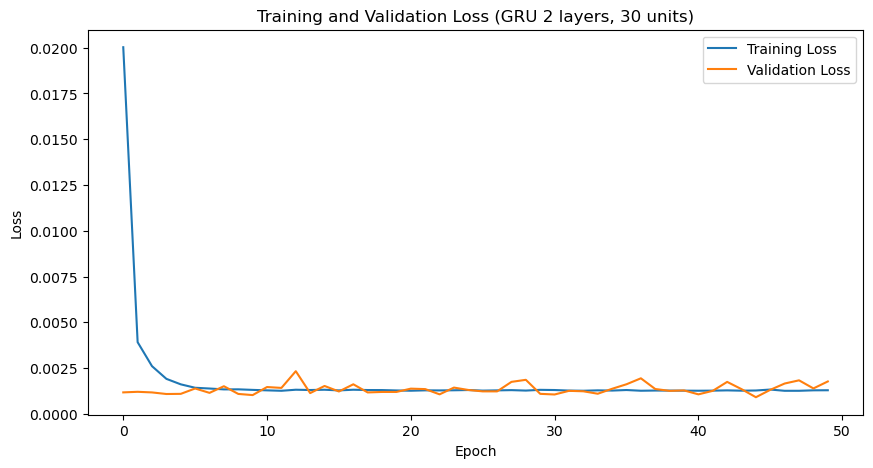

Epoch 1/50
145/145 [==============================] - 4s 16ms/step - loss: 0.0102 - val_loss: 9.6271e-04
Epoch 2/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0018 - val_loss: 8.9371e-04
Epoch 3/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0015 - val_loss: 8.5086e-04
Epoch 4/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 5/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 8.6474e-04
Epoch 6/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0013 - val_loss: 9.2744e-04
Epoch 7/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 8.9480e-04
Epoch 8/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 9/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0013 - val_loss: 8.8274e-04
Epoch 10/50
145/145 [==============================] - 2s 11ms/

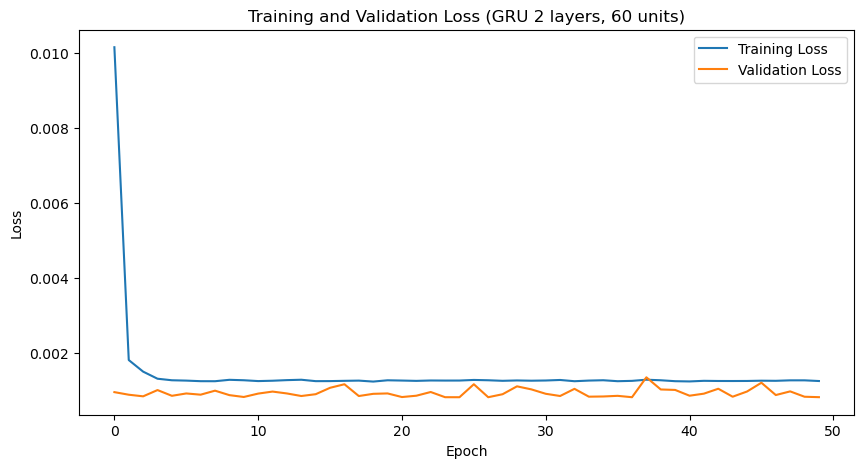

Epoch 1/50
145/145 [==============================] - 5s 22ms/step - loss: 0.0296 - val_loss: 0.0037
Epoch 2/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0065 - val_loss: 0.0034
Epoch 3/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0046 - val_loss: 0.0041
Epoch 4/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0035 - val_loss: 0.0043
Epoch 5/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0029 - val_loss: 0.0043
Epoch 6/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0022 - val_loss: 0.0043
Epoch 7/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0016 - val_loss: 0.0047
Epoch 8/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0015 - val_loss: 0.0051
Epoch 9/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0015 - val_loss: 0.0039
Epoch 10/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0015 - val_lo

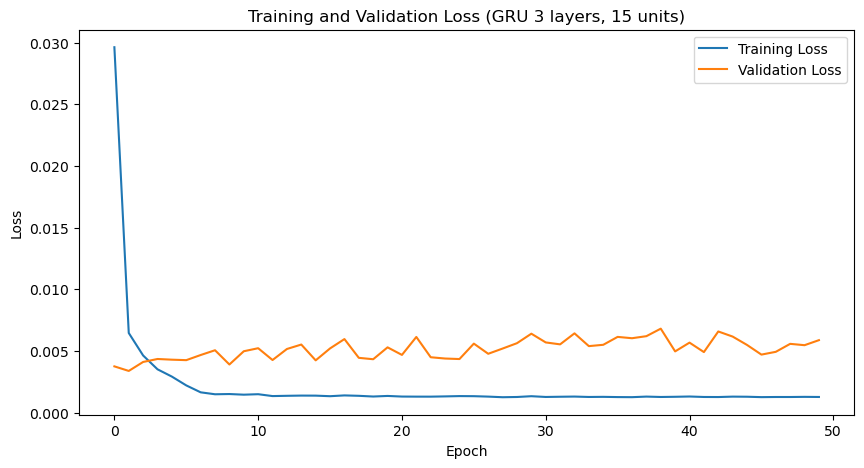

Epoch 1/50
145/145 [==============================] - 5s 20ms/step - loss: 0.0216 - val_loss: 0.0016
Epoch 2/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0035 - val_loss: 0.0017
Epoch 3/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 4/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0016 - val_loss: 9.0941e-04
Epoch 5/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 6/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 7/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 8/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0014 - val_loss: 9.0753e-04
Epoch 10/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0013 

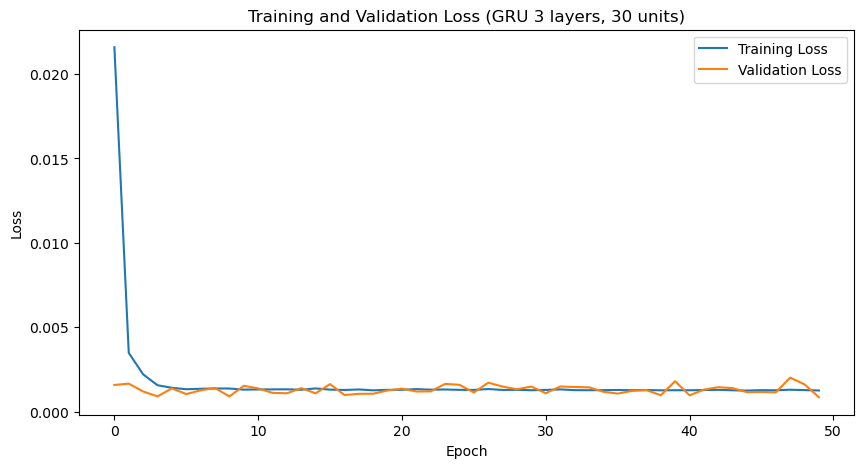

Epoch 1/50
145/145 [==============================] - 5s 21ms/step - loss: 0.0132 - val_loss: 0.0012
Epoch 2/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0015 - val_loss: 8.3821e-04
Epoch 4/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 8.2690e-04
Epoch 5/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 8.8355e-04
Epoch 6/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 9.3736e-04
Epoch 7/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 8/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 8.3577e-04
Epoch 9/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0013 - val_loss: 8.2780e-04
Epoch 10/50
145/145 [==============================] - 2s 13ms/step

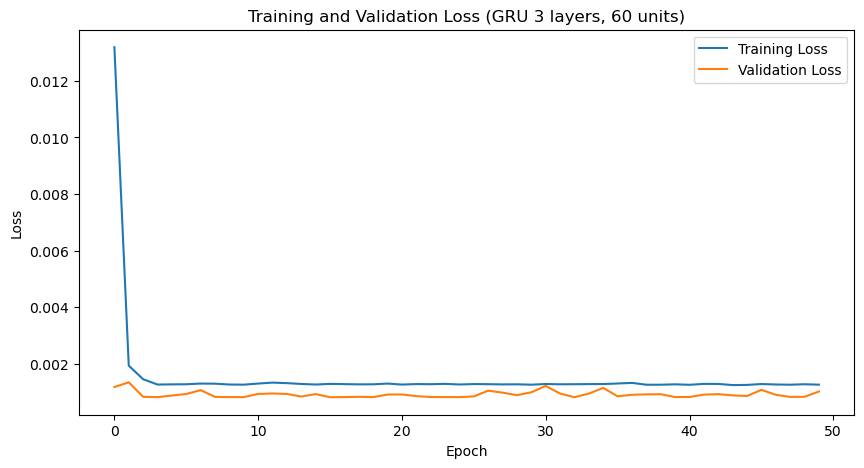

Best Model - Layers: 1, Units: 60 --> RMSE: 0.028872347346731005, MAE: 0.022168264766949042


In [11]:
layer_options = [1, 2, 3]  # Example: 1 to 3 GRU layers
unit_options = [15, 30, 60]  # Example: 20, 30, or 50 units

results = []

for num_layers in layer_options:
    for num_units in unit_options:
        model = create_gru_model(num_units, num_layers, input_shape=(None, 1))
        history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)
        test_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, test_pred))
        mae = mean_absolute_error(Y_test, test_pred)
        results.append((num_layers, num_units, rmse, mae))

        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"Training and Validation Loss (GRU {num_layers} layers, {num_units} units)")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

best_result = min(results, key=lambda x: x[2])  # Choose the model with the lowest RMSE
print(f"Best Model - Layers: {best_result[0]}, Units: {best_result[1]} --> RMSE: {best_result[2]}, MAE: {best_result[3]}")

In [12]:
for result in results:
    num_layers, num_units, rmse, mae = result
    print(f"Layers: {num_layers}, Units: {num_units} --> RMSE: {rmse}, MAE: {mae}")

Layers: 1, Units: 15 --> RMSE: 0.029224429002124304, MAE: 0.022610943271299453
Layers: 1, Units: 30 --> RMSE: 0.029046932945329645, MAE: 0.022291698498516442
Layers: 1, Units: 60 --> RMSE: 0.028872347346731005, MAE: 0.022168264766949042
Layers: 2, Units: 15 --> RMSE: 0.052312413425739245, MAE: 0.04558068860961403
Layers: 2, Units: 30 --> RMSE: 0.04149708910426942, MAE: 0.03509682695465414
Layers: 2, Units: 60 --> RMSE: 0.02891263616841476, MAE: 0.022212733738510775
Layers: 3, Units: 15 --> RMSE: 0.07532873879458561, MAE: 0.06887246442737649
Layers: 3, Units: 30 --> RMSE: 0.02936103132700928, MAE: 0.02274365421249377
Layers: 3, Units: 60 --> RMSE: 0.03233155122765772, MAE: 0.025324915664634247


# GRU optimizer and learning rate

In [14]:
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Sequential

def create_gru_model(optimizer, input_shape):
    model = Sequential()
    model.add(GRU(60, input_shape=input_shape))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

Epoch 1/50


2023-11-24 09:53:28.024181: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


145/145 [==============================] - 2s 11ms/step - loss: 0.0166 - val_loss: 0.0012
Epoch 2/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0010
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0010
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0017 - val_loss: 9.2846e-04
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 8.9836e-04
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 8.8936e-04
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 8.3506e-04
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 8.4033e-04
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0013 - val_lo

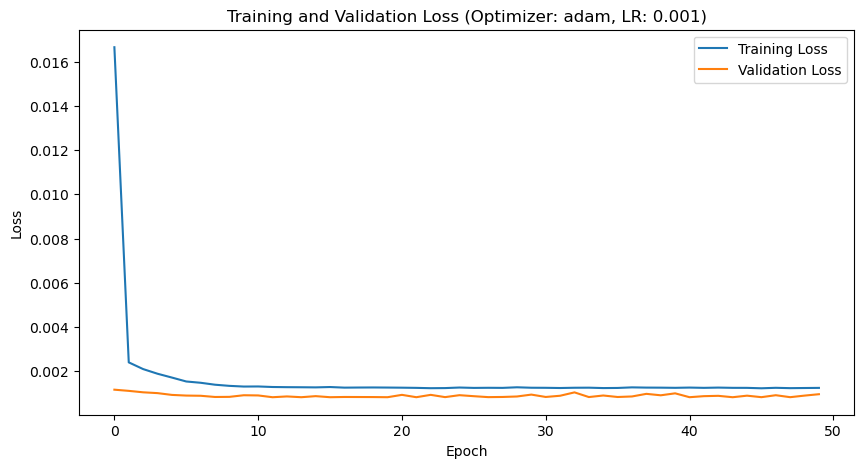

Epoch 1/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0055 - val_loss: 0.0010
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 8.3353e-04
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 8.9357e-04
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 8.5122e-04
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 8.7289e-04
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 8.3529e-04
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 9.4115e-04
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0013 - val_loss: 8.8535e-04
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 8.3176e-04
Epoch 10/50
145/145 [==============================] - 1s 7ms/step 

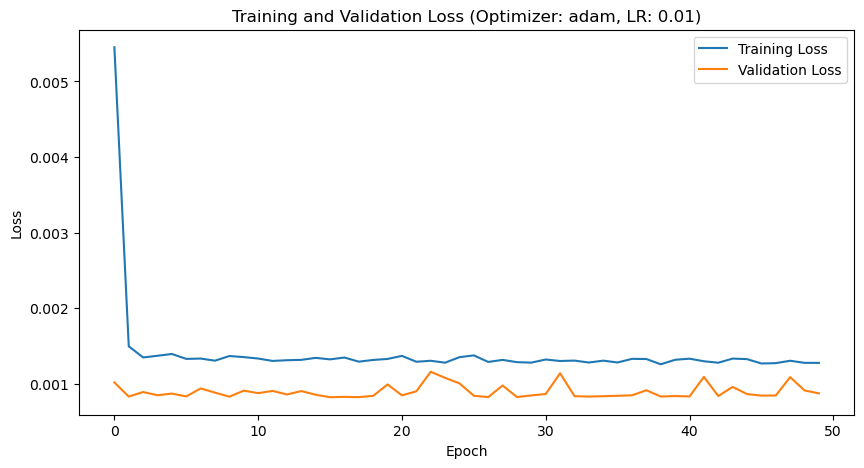

Epoch 1/50


2023-11-24 09:55:14.592675: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


145/145 [==============================] - 2s 11ms/step - loss: 0.0093 - val_loss: 0.0011
Epoch 2/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0016 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 8.6265e-04
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 8.2583e-04
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 8.9686e-04
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 8.5716e-04
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0015 - val_loss: 

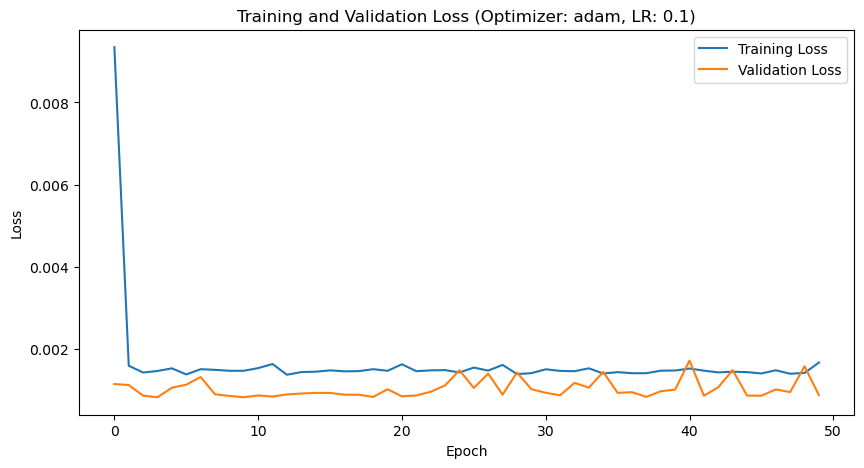

Epoch 1/50
145/145 [==============================] - 3s 13ms/step - loss: 0.0168 - val_loss: 0.0012
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 9.7298e-04
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 8.5945e-04
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.3139e-04
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 8.3377e-04
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 8.2702e-04
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 8.5534e-04
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 8.2454e-04
Epoch 10/50
145/145 [==============================] - 1s 9ms/step - lo

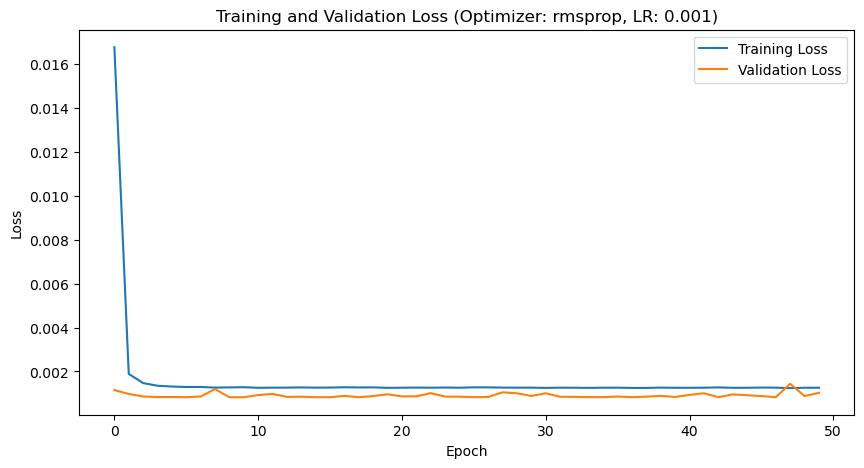

Epoch 1/50
145/145 [==============================] - 3s 14ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 8.9758e-04
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 8.6082e-04
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 8.5322e-04
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 9.6468e-04
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 9.0491e-04
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 9.5812e-04
Epoch 10/50
145/145 [==============================] - 1s 9ms/step - loss: 

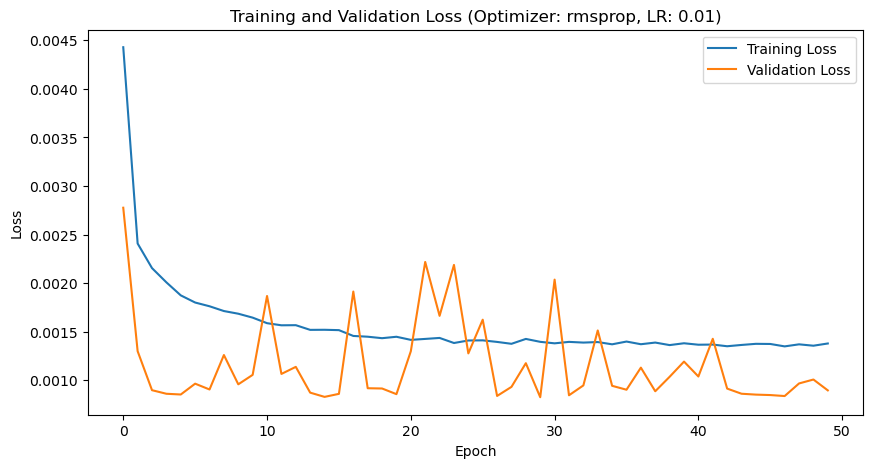

Epoch 1/50
145/145 [==============================] - 4s 14ms/step - loss: 0.2629 - val_loss: 0.0018
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0268 - val_loss: 0.0026
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0067 - val_loss: 0.0035
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0061 - val_loss: 0.0034
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0057 - val_loss: 0.0072
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.0025
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0019
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0052 - val_loss: 0.0053
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0023
Epoch 10/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0049 - val_loss: 0.010

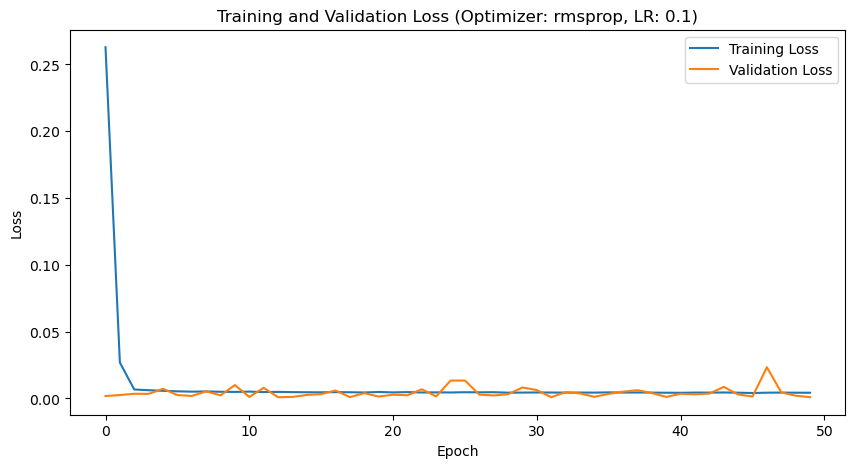

Epoch 1/50


2023-11-24 09:59:27.597572: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp_4.


145/145 [==============================] - 2s 10ms/step - loss: 0.1190 - val_loss: 0.0737
Epoch 2/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0518 - val_loss: 0.0318
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0237 - val_loss: 0.0143
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0120 - val_loss: 0.0071
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0071 - val_loss: 0.0041
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0051 - val_loss: 0.0029
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0043 - val_loss: 0.0024
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0039 - val_loss: 0.0022
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0038 - val_loss: 0.0022
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0021
Epoch 11/

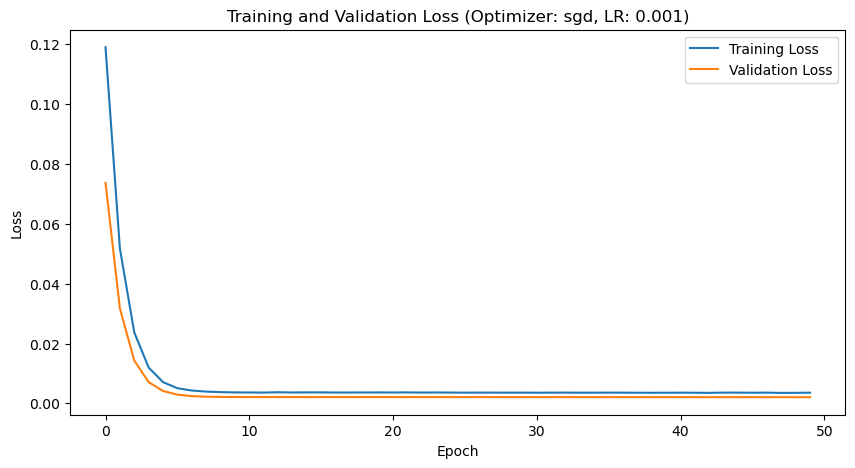

Epoch 1/50
145/145 [==============================] - 2s 10ms/step - loss: 0.0222 - val_loss: 0.0021
Epoch 2/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0039 - val_loss: 0.0021
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0020
Epoch 8/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0036 - val_loss: 0.0020
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.0020
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0035 - val_loss: 0.001

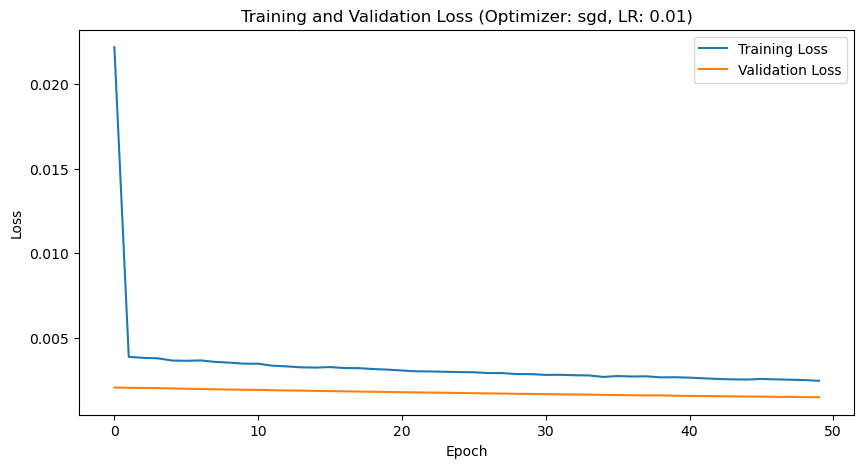

Epoch 1/50


2023-11-24 10:01:12.947716: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node SGD/AssignVariableOp_4.


145/145 [==============================] - 2s 11ms/step - loss: 0.0052 - val_loss: 0.0018
Epoch 2/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 3/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0028 - val_loss: 0.0017
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0026 - val_loss: 0.0016
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0013
Epoch 9/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 10/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 11/

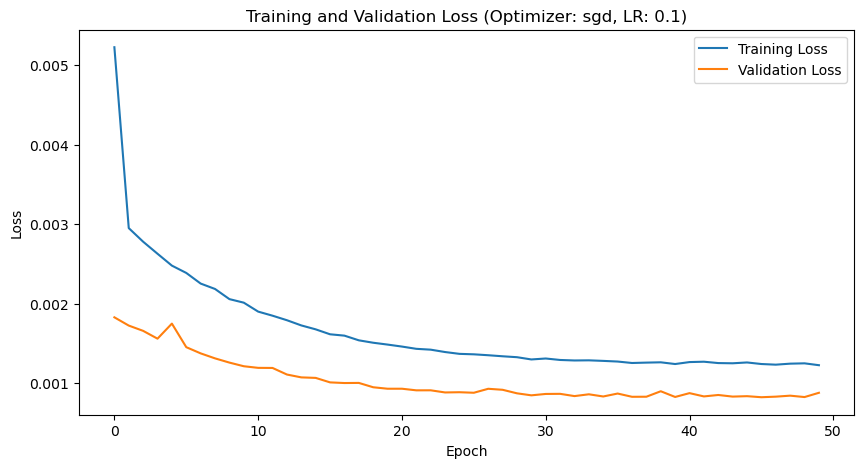

In [15]:
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

optimizers = {
    'adam': Adam,
    'rmsprop': RMSprop,
    'sgd': SGD
}
learning_rates = [0.001, 0.01, 0.1]

results = []

for opt_name, opt_class in optimizers.items():
    for lr in learning_rates:
        optimizer = opt_class(learning_rate=lr)
        model = create_gru_model(optimizer=optimizer, input_shape=(None, 1))
        history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)
        test_pred = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(Y_test, test_pred))
        mae = mean_absolute_error(Y_test, test_pred)
        results.append((opt_name, lr, rmse, mae))
        
        # Plot training and validation loss
        plt.figure(figsize=(10, 5))
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"Training and Validation Loss (Optimizer: {opt_name}, LR: {lr})")
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

In [16]:
best_result = min(results, key=lambda x: x[2])  # Choose the model with the lowest RMSE
print(f"Best Model - Optimizer: {best_result[0]}, Learning Rate: {best_result[1]} --> RMSE: {best_result[2]}, MAE: {best_result[3]}")

Best Model - Optimizer: adam, Learning Rate: 0.1 --> RMSE: 0.029627763749121364, MAE: 0.022933497948702523


In [17]:
for result in results:
    num_layers, num_units, rmse, mae = result
    print(f"Layers: {num_layers}, Units: {num_units} --> RMSE: {rmse}, MAE: {mae}")

Layers: adam, Units: 0.001 --> RMSE: 0.03137209463900343, MAE: 0.02435431242953691
Layers: adam, Units: 0.01 --> RMSE: 0.029672230143093375, MAE: 0.022951685424375298
Layers: adam, Units: 0.1 --> RMSE: 0.029627763749121364, MAE: 0.022933497948702523
Layers: rmsprop, Units: 0.001 --> RMSE: 0.03241606478838316, MAE: 0.02531276871849897
Layers: rmsprop, Units: 0.01 --> RMSE: 0.03028959306851733, MAE: 0.023344824167760868
Layers: rmsprop, Units: 0.1 --> RMSE: 0.03048620789574999, MAE: 0.023969961142679463
Layers: sgd, Units: 0.001 --> RMSE: 0.04678018197289733, MAE: 0.03646021062402642
Layers: sgd, Units: 0.01 --> RMSE: 0.03955863480700156, MAE: 0.03082716592681224
Layers: sgd, Units: 0.1 --> RMSE: 0.03003940014038454, MAE: 0.023092123849548472


# Hybrid model

In [18]:
from tensorflow.keras.layers import LSTM, GRU, Dense
from tensorflow.keras.models import Sequential

def create_hybrid_model(input_shape):
    model = Sequential()
    # LSTM layer - can capture long-term dependencies
    model.add(LSTM(60, return_sequences=True, input_shape=input_shape))
    # GRU layer - can capture short-term patterns more efficiently
    model.add(GRU(60, return_sequences=False))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Epoch 1/50
145/145 [==============================] - 3s 16ms/step - loss: 0.0169 - val_loss: 0.0013
Epoch 2/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0016 - val_loss: 9.8359e-04
Epoch 4/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0014 - val_loss: 8.9597e-04
Epoch 5/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 8.3563e-04
Epoch 6/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 9.6114e-04
Epoch 7/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 8.2959e-04
Epoch 8/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0012 - val_loss: 8.2381e-04
Epoch 9/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0013 - val_loss: 8.3013e-04
Epoch 10/50
145/145 [==============================] - 1s 10ms/

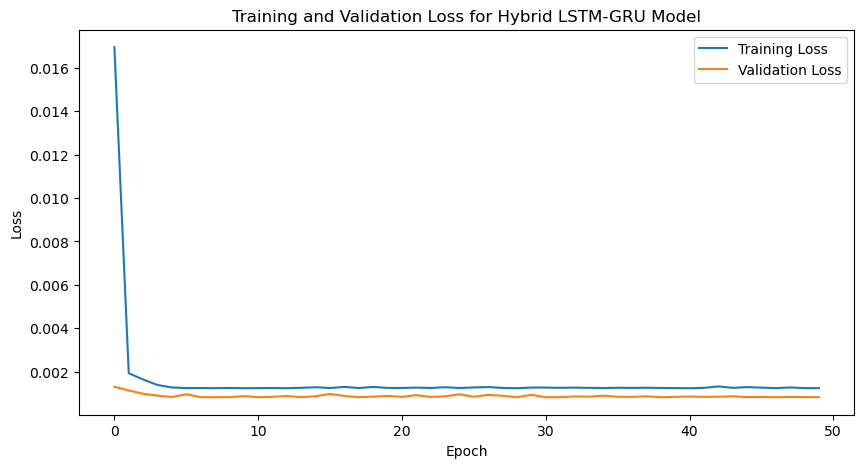

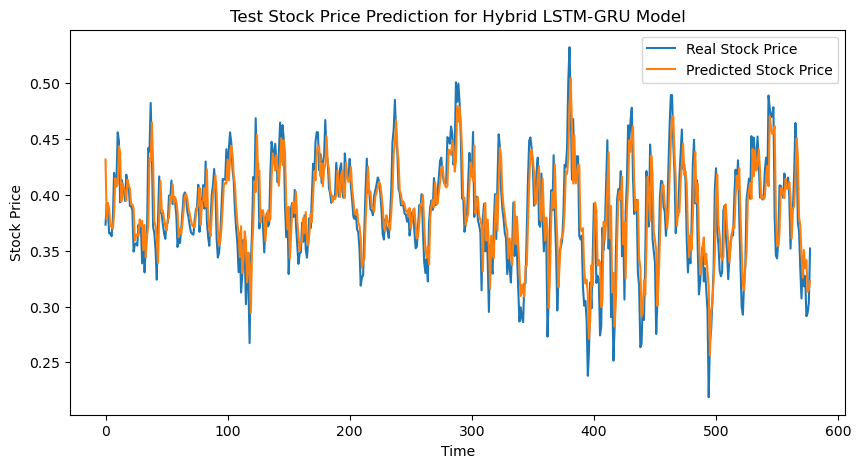

In [19]:
# Assume X_train, Y_train, X_valid, Y_valid, X_test, Y_test are already defined and properly preprocessed

# Create the model
model = create_hybrid_model(input_shape=(None, 1))

# Train the model
history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)

# Evaluate the model
test_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(Y_test, test_pred))
mae = mean_absolute_error(Y_test, test_pred)

# Print out the metrics
print(f"Test RMSE: {rmse}, Test MAE: {mae}")

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss for Hybrid LSTM-GRU Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot predicted vs real stock prices
plt.figure(figsize=(10, 5))
plt.plot(Y_test, label='Real Stock Price')
plt.plot(test_pred, label='Predicted Stock Price')
plt.title('Test Stock Price Prediction for Hybrid LSTM-GRU Model')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Handmade RNN

In [20]:
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

def create_rnn_model(num_units, activation, dropout_rate, input_shape):
    model = Sequential()
    model.add(SimpleRNN(num_units, activation=activation, input_shape=input_shape, return_sequences=False))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

Training RNN model with 15 units, activation relu, and dropout rate 0
Epoch 1/50
145/145 [==============================] - 3s 12ms/step - loss: 0.0213 - val_loss: 9.9694e-04
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 9.8319e-04
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 9.6641e-04
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 9.5303e-04
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 9.2960e-04
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 9.1055e-04
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 8.9259e-04
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.7661e-04
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.64

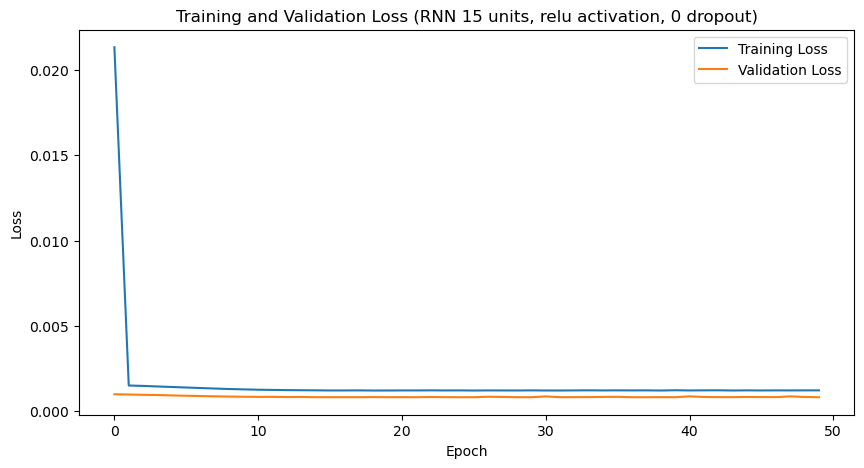

Training RNN model with 15 units, activation relu, and dropout rate 0.2
Epoch 1/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0898 - val_loss: 0.0030
Epoch 2/50
145/145 [==============================] - 1s 10ms/step - loss: 0.0087 - val_loss: 0.0016
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0075 - val_loss: 0.0016
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0065 - val_loss: 0.0016
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0060 - val_loss: 0.0016
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0056 - val_loss: 0.0015
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0043 - val_loss: 0.0014
Epoch 10/50
145/145 [=====

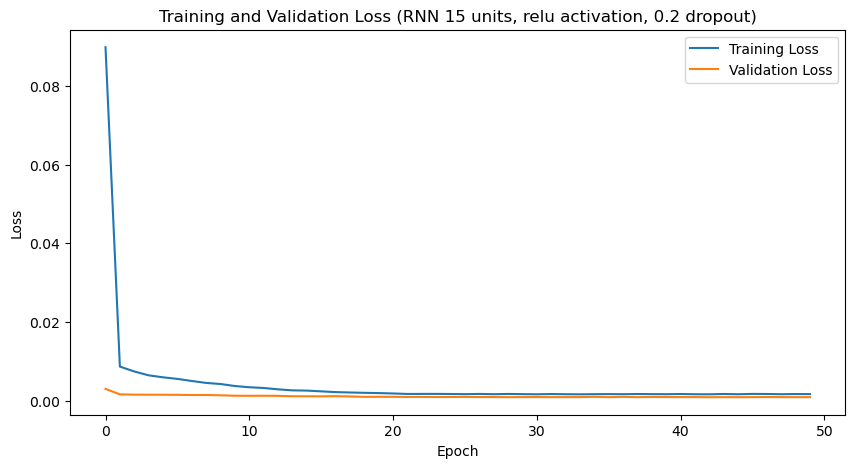

Training RNN model with 15 units, activation relu, and dropout rate 0.5
Epoch 1/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0254 - val_loss: 0.0029
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0102 - val_loss: 0.0017
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0069 - val_loss: 0.0014
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0045 - val_loss: 0.0012
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 0.0011
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 10/50
145/145 [======

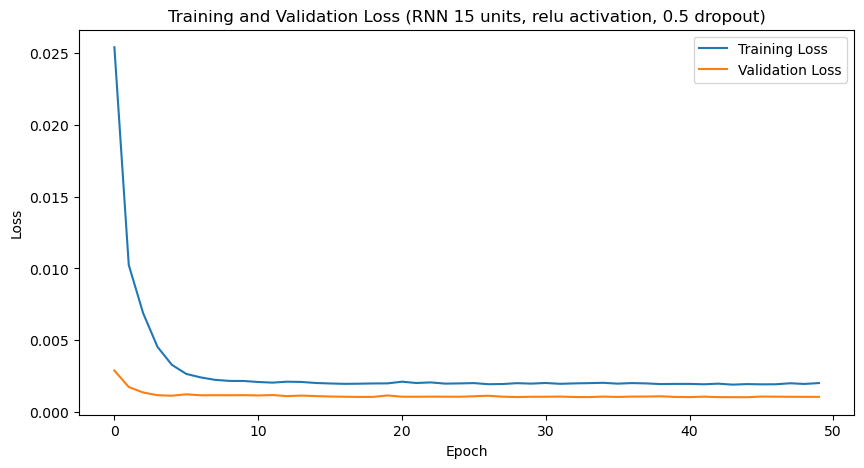

Training RNN model with 15 units, activation tanh, and dropout rate 0
Epoch 1/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0570 - val_loss: 0.0020
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0019
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0029 - val_loss: 0.0017
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0027 - val_loss: 0.0016
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0025 - val_loss: 0.0015
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0012
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0019 - val_loss: 0.0011
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 10/50
145/145 [========

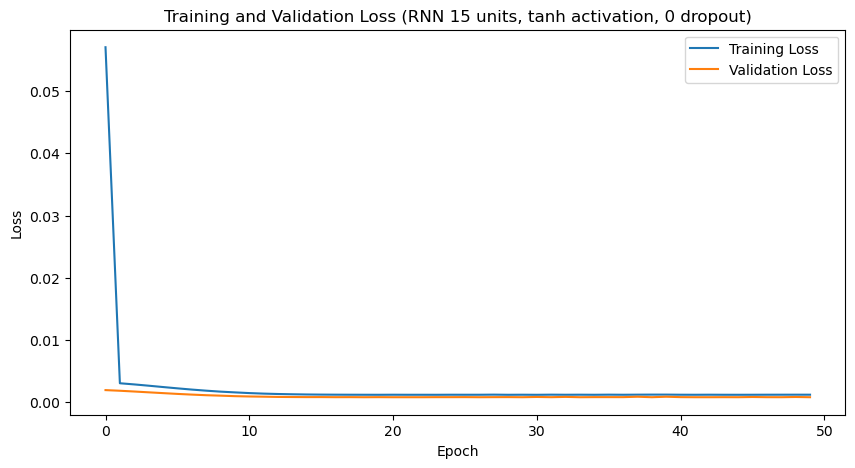

Training RNN model with 15 units, activation tanh, and dropout rate 0.2
Epoch 1/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0411 - val_loss: 0.0016
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0064 - val_loss: 0.0017
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0053 - val_loss: 0.0016
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0014
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0015
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0027 - val_loss: 0.0013
Epoch 10/50
145/145 [======

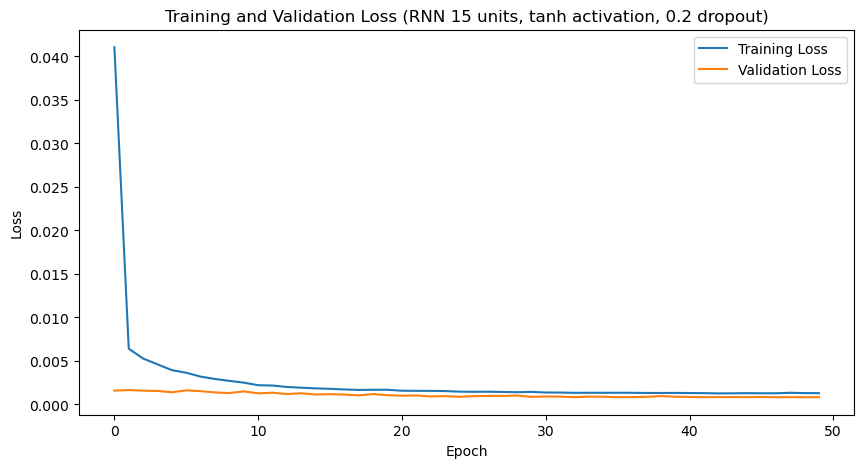

Training RNN model with 15 units, activation tanh, and dropout rate 0.5
Epoch 1/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0261 - val_loss: 0.0021
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0060 - val_loss: 0.0014
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0033 - val_loss: 0.0014
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 8.7131e-04
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0020 - val_loss: 9.2321e-04
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 8.6242e-04
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 8.4767e-04
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 8.5114e-04
Epoch 1

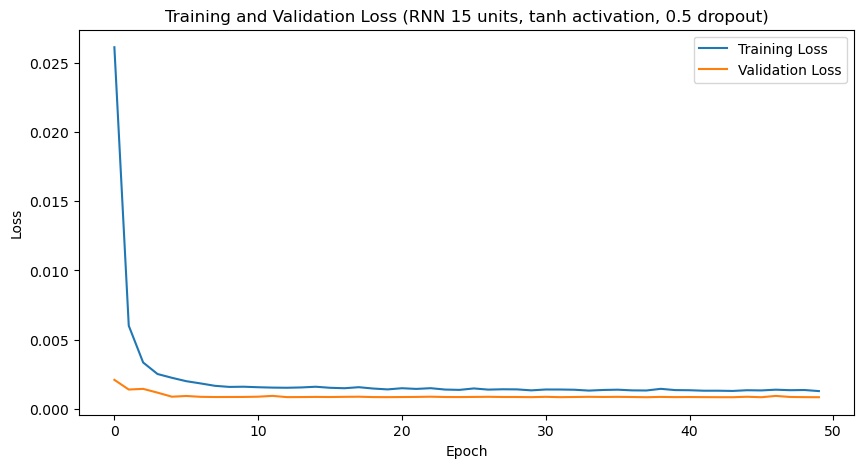

Training RNN model with 30 units, activation relu, and dropout rate 0
Epoch 1/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0242 - val_loss: 0.0011
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 9.9842e-04
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 9.5062e-04
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 9.2585e-04
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 9.0480e-04
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.8330e-04
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.7006e-04
Epoch

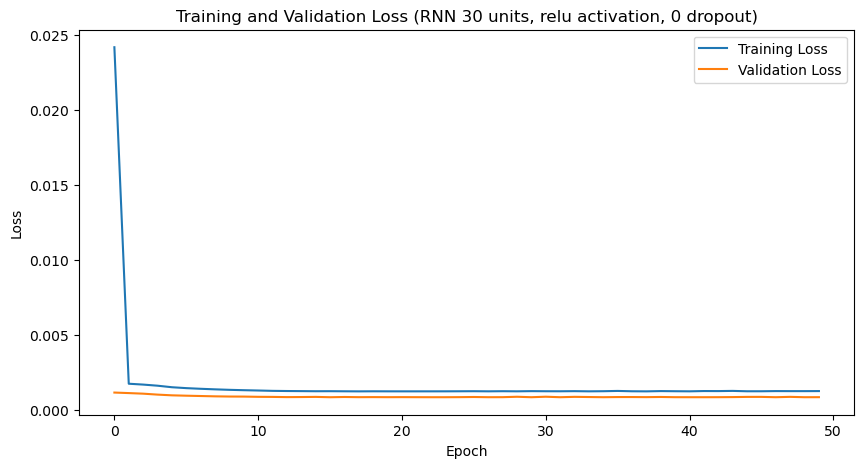

Training RNN model with 30 units, activation relu, and dropout rate 0.2
Epoch 1/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0402 - val_loss: 0.0018
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0065 - val_loss: 0.0017
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0057 - val_loss: 0.0015
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0041 - val_loss: 0.0013
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0037 - val_loss: 0.0012
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0031 - val_loss: 0.0011
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 9.7190e-04
Epoch 10/50
145/145 [==

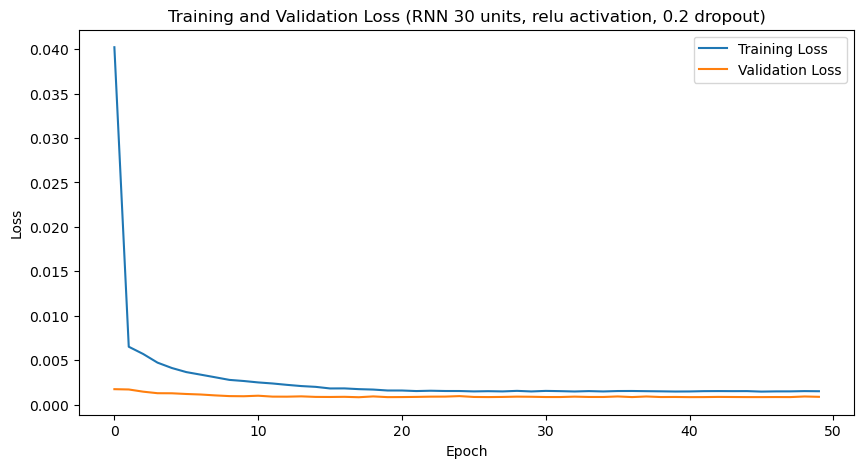

Training RNN model with 30 units, activation relu, and dropout rate 0.5
Epoch 1/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0353 - val_loss: 0.0041
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0139 - val_loss: 0.0031
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0096 - val_loss: 0.0022
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0065 - val_loss: 0.0018
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0047 - val_loss: 0.0015
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0036 - val_loss: 0.0012
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0025 - val_loss: 0.0012
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0024 - val_loss: 0.0012
Epoch 10/50
145/145 [======

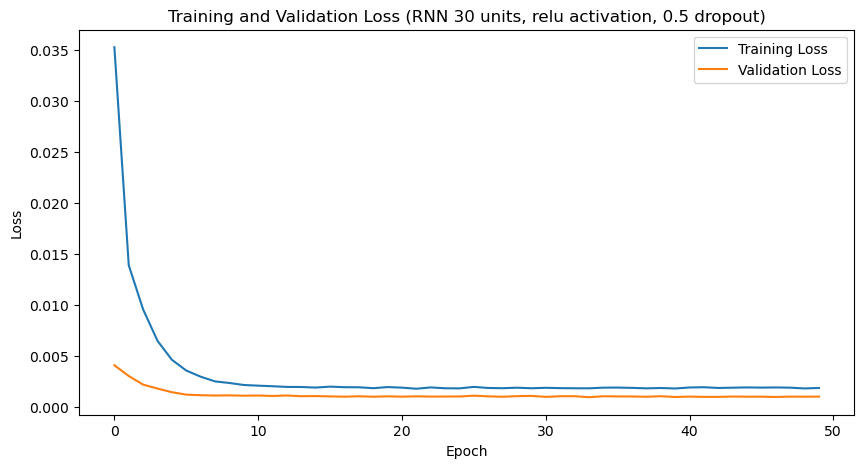

Training RNN model with 30 units, activation tanh, and dropout rate 0
Epoch 1/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0073 - val_loss: 9.3790e-04
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 9.0772e-04
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.7656e-04
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.5492e-04
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.3541e-04
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 8.2913e-04
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 8.2503e-04
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 8.2433e-04
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 8.37

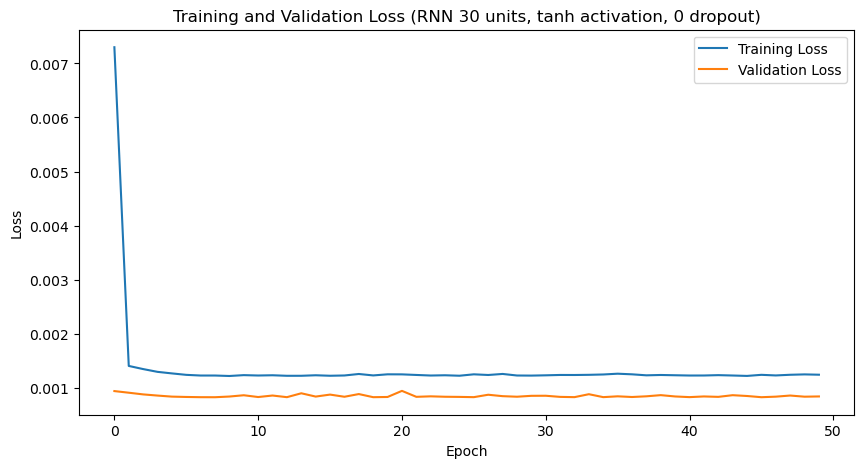

Training RNN model with 30 units, activation tanh, and dropout rate 0.2
Epoch 1/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0128 - val_loss: 9.7438e-04
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0040 - val_loss: 9.2822e-04
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 8.9117e-04
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0022 - val_loss: 8.9321e-04
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 9.6685e-04
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 8.7392e-04
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 9.8757e-04
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 9.7520e-04
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 9.

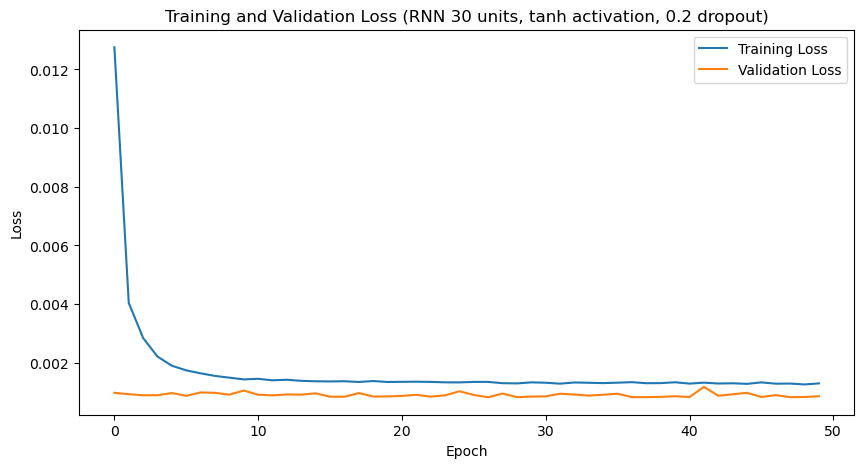

Training RNN model with 30 units, activation tanh, and dropout rate 0.5
Epoch 1/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0413 - val_loss: 0.0041
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0098 - val_loss: 0.0033
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0058 - val_loss: 0.0026
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0038 - val_loss: 0.0020
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 0.0017
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0028 - val_loss: 0.0016
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0026 - val_loss: 0.0017
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0013
Epoch 10/50
145/145 [======

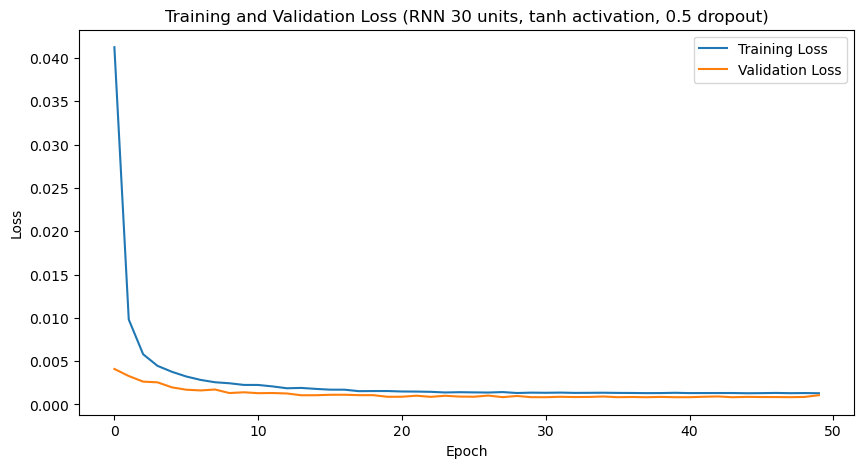

Training RNN model with 60 units, activation relu, and dropout rate 0
Epoch 1/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0112 - val_loss: 9.3205e-04
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 9.1241e-04
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 9.0827e-04
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.7846e-04
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.5547e-04
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.4332e-04
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 8.3264e-04
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 8.3208e-04
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 8.30

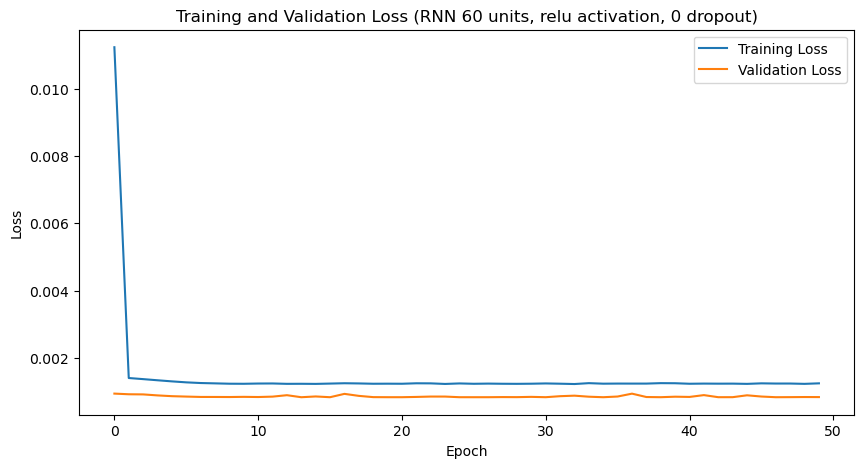

Training RNN model with 60 units, activation relu, and dropout rate 0.2
Epoch 1/50
145/145 [==============================] - 2s 14ms/step - loss: 0.0159 - val_loss: 0.0011
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0032 - val_loss: 9.9933e-04
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0027 - val_loss: 9.3064e-04
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0024 - val_loss: 0.0011
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 8.9401e-04
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 9.4520e-04
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 9.0294e-04
Epoch 1

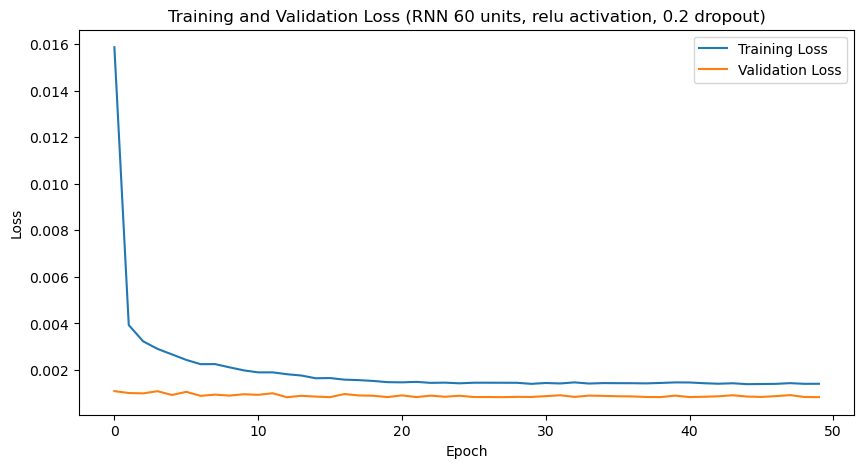

Training RNN model with 60 units, activation relu, and dropout rate 0.5
Epoch 1/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0320 - val_loss: 0.0025
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0080 - val_loss: 0.0022
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0061 - val_loss: 0.0020
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0051 - val_loss: 0.0021
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0045 - val_loss: 0.0016
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0040 - val_loss: 0.0016
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0035 - val_loss: 0.0014
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0028 - val_loss: 0.0013
Epoch 10/50
145/145 [======

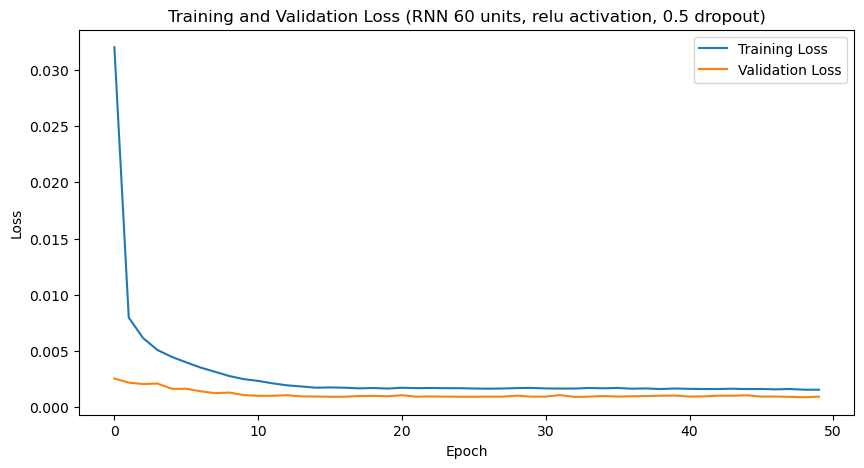

Training RNN model with 60 units, activation tanh, and dropout rate 0
Epoch 1/50
145/145 [==============================] - 2s 11ms/step - loss: 0.0247 - val_loss: 0.0014
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 5/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 9.5273e-04
Epoch 6/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0014 - val_loss: 8.8558e-04
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.7083e-04
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 8.3270e-04
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0012 - val_loss: 8.2580e-04
Epoch 10/

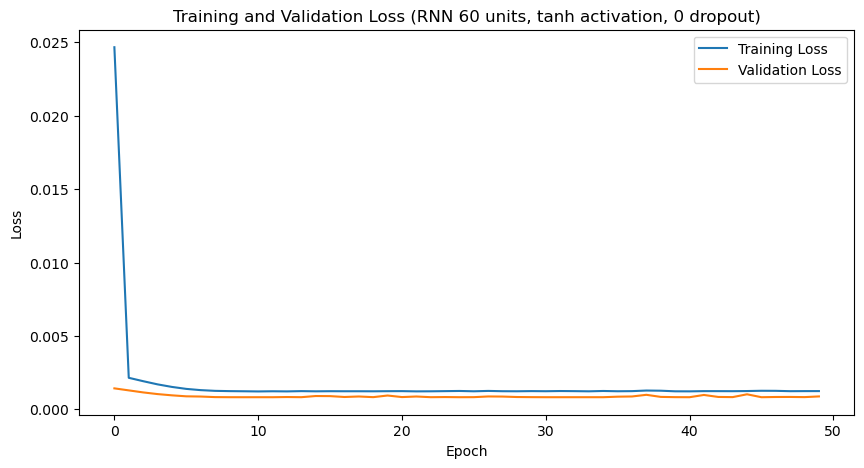

Training RNN model with 60 units, activation tanh, and dropout rate 0.2
Epoch 1/50
145/145 [==============================] - 2s 13ms/step - loss: 0.0150 - val_loss: 0.0012
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0021 - val_loss: 9.6231e-04
Epoch 4/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0018 - val_loss: 9.2107e-04
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0016 - val_loss: 8.5337e-04
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0015 - val_loss: 8.8445e-04
Epoch 7/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 8/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 8.3049e-04
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 8.3114e-04
Epo

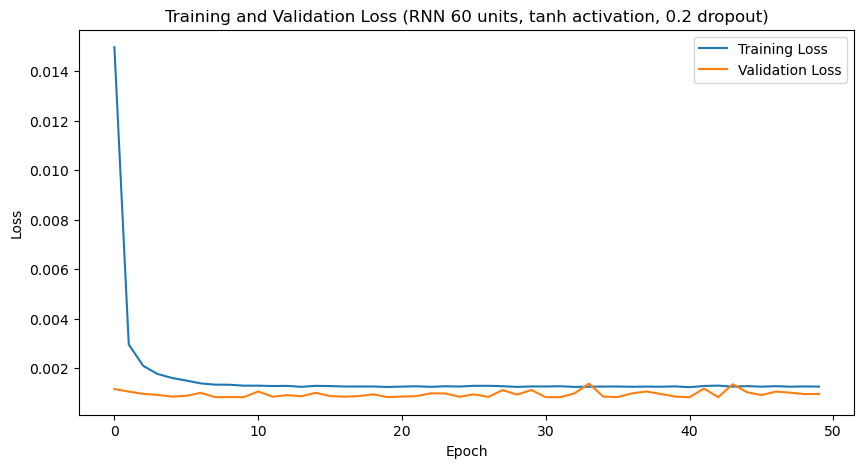

Training RNN model with 60 units, activation tanh, and dropout rate 0.5
Epoch 1/50
145/145 [==============================] - 3s 14ms/step - loss: 0.0139 - val_loss: 9.3485e-04
Epoch 2/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0029 - val_loss: 9.0553e-04
Epoch 3/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0017 - val_loss: 0.0012
Epoch 4/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 5/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 9.9092e-04
Epoch 6/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 7/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0013 - val_loss: 0.0017
Epoch 9/50
145/145 [==============================] - 1s 9ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 10/50
145

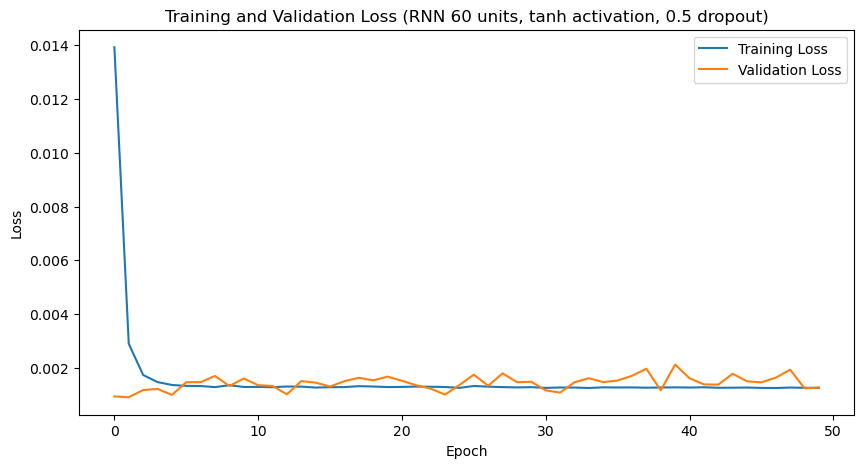

In [21]:
# Define grid search parameters
unit_options = [15, 30, 60]  # Number of units in the RNN layer
activation_options = ['relu', 'tanh']  # Activation functions to try
dropout_options = [0, 0.2, 0.5]  # Dropout rates to try

results = []

for num_units in unit_options:
    for activation in activation_options:
        for dropout_rate in dropout_options:
            print(f"Training RNN model with {num_units} units, activation {activation}, and dropout rate {dropout_rate}")
            model = create_rnn_model(num_units=num_units, activation=activation, dropout_rate=dropout_rate, input_shape=(None, 1))
            
            # Train the model
            history = model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)
            
            # Evaluate the model
            test_pred = model.predict(X_test)
            rmse = np.sqrt(mean_squared_error(Y_test, test_pred))
            mae = mean_absolute_error(Y_test, test_pred)
            
            # Store metrics
            results.append((num_units, activation, dropout_rate, rmse, mae))
            
            # Plot training and validation loss
            plt.figure(figsize=(10, 5))
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f"Training and Validation Loss (RNN {num_units} units, {activation} activation, {dropout_rate} dropout)")
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

In [22]:
# Print the results
best_result = min(results, key=lambda x: x[3])  # Choose the model with the lowest RMSE
print(f"Best Model - Units: {best_result[0]}, Activation: {best_result[1]}, Dropout Rate: {best_result[2]} --> RMSE: {best_result[3]}, MAE: {best_result[4]}")

Best Model - Units: 30, Activation: relu, Dropout Rate: 0 --> RMSE: 0.02886434540004539, MAE: 0.022192995050081942


# Best of LSTM and GRU dropout comparison

In [23]:
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from tensorflow.keras.models import Sequential

# Function to create the LSTM model
def create_lstm_model(use_dropout, input_shape):
    model = Sequential()
    model.add(LSTM(30, input_shape=input_shape))
    if use_dropout:
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

# Function to create the GRU model
def create_gru_model(use_dropout, input_shape):
    model = Sequential()
    model.add(GRU(60, input_shape=input_shape))
    if use_dropout:
        model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [24]:
# Assuming the data is already prepared
# X_train, Y_train, X_valid, Y_valid, X_test, Y_test

# LSTM Model Comparison
lstm_no_dropout_model = create_lstm_model(use_dropout=False, input_shape=(X_train.shape[1], X_train.shape[2]))
lstm_dropout_model = create_lstm_model(use_dropout=True, input_shape=(X_train.shape[1], X_train.shape[2]))

# Train LSTM models
history_lstm_no_dropout = lstm_no_dropout_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)
history_lstm_dropout = lstm_dropout_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)

# GRU Model Comparison
gru_no_dropout_model = create_gru_model(use_dropout=False, input_shape=(X_train.shape[1], X_train.shape[2]))
gru_dropout_model = create_gru_model(use_dropout=True, input_shape=(X_train.shape[1], X_train.shape[2]))

# Train GRU models
history_gru_no_dropout = gru_no_dropout_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)
history_gru_dropout = gru_dropout_model.fit(X_train, Y_train, epochs=50, batch_size=32, validation_data=(X_valid, Y_valid), verbose=1)

Epoch 1/50
145/145 [==============================] - 2s 12ms/step - loss: 0.0544 - val_loss: 0.0015
Epoch 2/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0023 - val_loss: 0.0014
Epoch 3/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0022 - val_loss: 0.0014
Epoch 4/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 5/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0021 - val_loss: 0.0013
Epoch 6/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0020 - val_loss: 0.0012
Epoch 7/50
145/145 [==============================] - 1s 7ms/step - loss: 0.0019 - val_loss: 0.0012
Epoch 8/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0018 - val_loss: 0.0011
Epoch 9/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0017 - val_loss: 0.0010
Epoch 10/50
145/145 [==============================] - 1s 8ms/step - loss: 0.0016 - val_loss: 9.968

In [25]:
# Evaluate LSTM models
lstm_no_dropout_pred = lstm_no_dropout_model.predict(X_test)
lstm_dropout_pred = lstm_dropout_model.predict(X_test)
lstm_no_dropout_rmse = np.sqrt(mean_squared_error(Y_test, lstm_no_dropout_pred))
lstm_dropout_rmse = np.sqrt(mean_squared_error(Y_test, lstm_dropout_pred))

# Evaluate GRU models
gru_no_dropout_pred = gru_no_dropout_model.predict(X_test)
gru_dropout_pred = gru_dropout_model.predict(X_test)
gru_no_dropout_rmse = np.sqrt(mean_squared_error(Y_test, gru_no_dropout_pred))
gru_dropout_rmse = np.sqrt(mean_squared_error(Y_test, gru_dropout_pred))

# Print RMSE for comparison
print(f"LSTM without dropout RMSE: {lstm_no_dropout_rmse}")
print(f"LSTM with dropout RMSE: {lstm_dropout_rmse}")
print(f"GRU without dropout RMSE: {gru_no_dropout_rmse}")
print(f"GRU with dropout RMSE: {gru_dropout_rmse}")

# Determine the better model for each comparison
# For LSTM
better_lstm_model = lstm_dropout_model if lstm_dropout_rmse < lstm_no_dropout_rmse else lstm_no_dropout_model
better_lstm_pred = lstm_dropout_pred if lstm_dropout_rmse < lstm_no_dropout_rmse else lstm_no_dropout_pred

# For GRU
better_gru_model = gru_dropout_model if gru_dropout_rmse < gru_no_dropout_rmse else gru_no_dropout_model
better_gru_pred = gru_dropout_pred if gru_dropout_rmse < gru_no_dropout_rmse else gru_no_dropout_pred

19/19 [==============================] - 0s 4ms/step
LSTM without dropout RMSE: 0.02938907153865036
LSTM with dropout RMSE: 0.029368821673410046
GRU without dropout RMSE: 0.029606221818281396
GRU with dropout RMSE: 0.02886304440316295


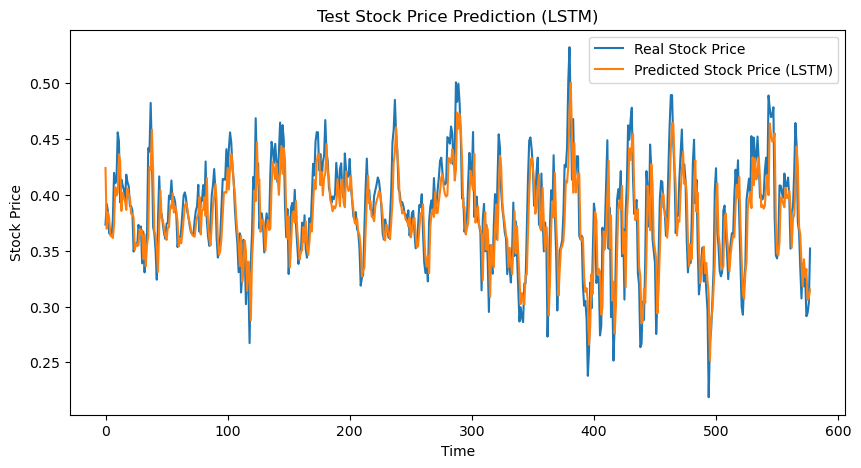

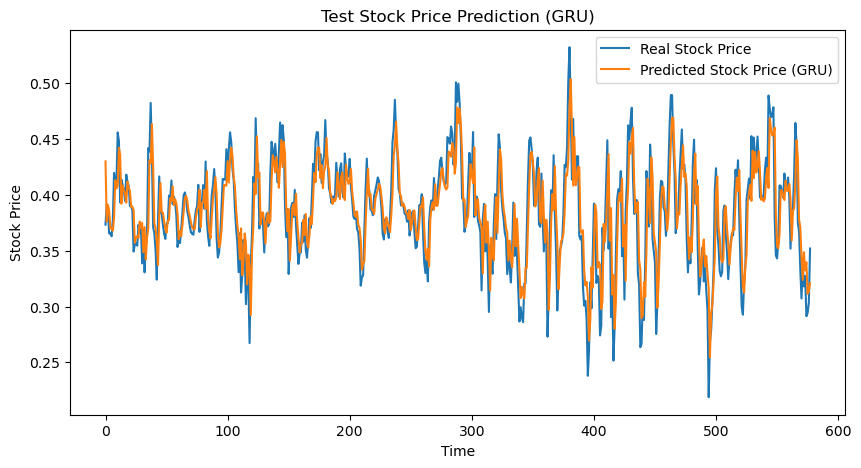

In [26]:
# For the better LSTM model
plt.figure(figsize=(10, 5))
plt.plot(Y_test, label='Real Stock Price')
plt.plot(better_lstm_pred, label='Predicted Stock Price (LSTM)')
plt.title('Test Stock Price Prediction (LSTM)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# For the better GRU model
plt.figure(figsize=(10, 5))
plt.plot(Y_test, label='Real Stock Price')
plt.plot(better_gru_pred, label='Predicted Stock Price (GRU)')
plt.title('Test Stock Price Prediction (GRU)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()